# K-nearest neighbours
K-nearest neighbours (KNN) is a supervised classification algorithm that works by looking at neighbouring points in the dataset to classify new unknown data points. Or, to put it in another way, if you were to plot the data in a graph, points that are close together will probably have the same label. The K in the name stands for the number of nearest neighbours to consider for making the classification.

A trained KNN model basically consists of the training data since the classification is done by comparing the known data to the new data. However, since the model goes through all of the training data for every prediction, this can make these models slow if the training data is large.

The excellent Scikit Learn package has prebuilt functions available to use, so we don't actually need to do much programming at all.

## Learning Objectives

Average time to complete: 60min

By the end of this tutorial, you should be able to:
* Apply the KNN algorithm to various datasets
* Use visualization techniques to explore the data
* Use one-hot encoding
* Improve the model using hyperparameter tuning
* Appreciate the limits of the algorithm
* Impute data using fixed value replacement or linear regression

## What you will need for this tutorial

* See the [introduction document](https://uottawa-it-research-teaching.github.io/machinelearning/) for general requirements and how Jupyter notebooks work.
* We'll need Pandas for convenient data handling. It's a very powerful Python package that can read CSV and Excel files. It also has very good data manipulation capabilities which come in use for data cleaning.
* We will use scikit-learn as our machine learning package.
* The data files that should have come with this notebook.

## RDM best practices

Good data handling for machine learning begins with good Research Data Management (RDM). The quality of your source data will impact the outcome of your results, just like the reproducibility of your results will depend on the quality of your data sources, in addition to how you organize the data so that other people (and machines!) can understand and reuse it. 

We also need to respect a few research data management best practices along the way, these best practices are recommended by the [Digital Research Alliance of Canada](https://zenodo.org/records/4000989).

SAVE YOUR RAW DATA IN ORIGINAL FORMAT
* Don't overwrite your original data with a cleaned version.
* Protect your original data by locking them or making them read-only.
* Refer to this original data if things go wrong (as they often do).

BACKUP YOUR DATA
* Use the 3-2-1 rule: Save three copies of your data, on two different storage mediums, and one copy off site. The off site storage can be OneDrive or Google drive or whatever your institution provides.
* We are using Open Data, so it does not contain any personally identifiable data or data that needs to be restricted or protected in any way. However, if your data contains confidential information, it is important to take steps to restrict access and encrypt your data.

There are a few more RDM best practices that will help you in your project management, and we will highlight them at the beginning of each tutorial. 

The first step here is to import the packages that we need. As mentioned, we'll use Pandas and SciKit Learn. We'll also import NumPy which has some nice helper functions available. We'll also import the Seaborn plotting library which will help us visualize the data.


In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, hamming_loss, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
import pandas as pd
import numpy as np
import seaborn as sns

# Penguins Dataset Example
Since this is a supervised learning algorithm, we need train with a dataset that is already labelled. One popular dataset to explore this technique is the Palmer Penguins dataset that is available on [CRAN](https://cran.r-project.org/web/packages/palmerpenguins/index.html). It contains measurements of various physical properties of different species of penguins. It's a nice dataset because it works with only two features, which means it's easy to plot in 2D. It's included in the Seaborn plotting library so we don't need to download it separately.

First, we'll drop the rows with missing data. Normally, you'd want to try to fill in the missing data as best as you can like we did before with the bike/weather dataset in the tutorial about linear regression, but for the sake of simplicity and because we have enough complete rows to train the algorithm, we will continue without fixing missing data.

In [8]:
penguins = sns.load_dataset('penguins').dropna()

In [9]:
penguins

species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0    Adelie  Torgersen            39.1           18.7              181.0   
1    Adelie  Torgersen            39.5           17.4              186.0   
2    Adelie  Torgersen            40.3           18.0              195.0   
4    Adelie  Torgersen            36.7           19.3              193.0   
5    Adelie  Torgersen            39.3           20.6              190.0   
..      ...        ...             ...            ...                ...   
338  Gentoo     Biscoe            47.2           13.7              214.0   
340  Gentoo     Biscoe            46.8           14.3              215.0   
341  Gentoo     Biscoe            50.4           15.7              222.0   
342  Gentoo     Biscoe            45.2           14.8              212.0   
343  Gentoo     Biscoe            49.9           16.1              213.0   

     body_mass_g     sex  
0         3750.0    Male  
1         3800.0  Female  
2         3250.0  Female  
4         3450.0  Female  
5         3650.0    Male  
..           ...     ...  
338       4925.0  Female  
340       4850.0  Female  
341       5750.0    Male  
342       5200.0  Female  
343       5400.0    Male  

[333 rows x 7 columns]

To make sense of the data and to see if KNN could be effective, we will want to plot the data. As mentioned before, KNN works by looking at neighbouring points for its classification predictions, so we will want to make a plot of one feature against another to see if there are distinct regions.

The Seaborn plotting library has a nice plotting function called "pairplot" which does exactly that. We make a pair plot of the bill dimensions and colour by species. This shows that there is indeed a relatively good split because you can clearly see the distinct regions. Remember that KNN labels unknown data points based on proximity to known data points.

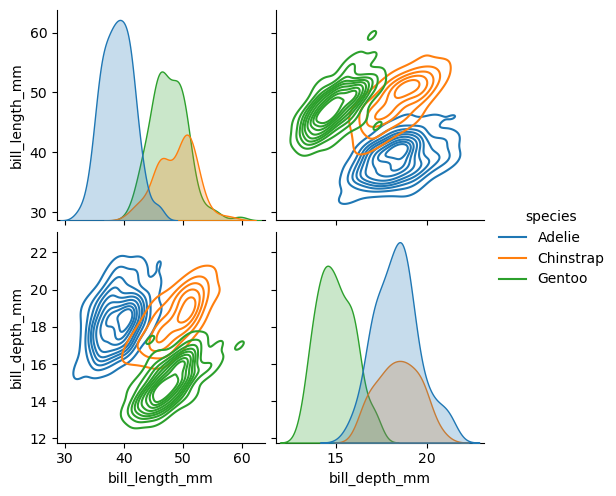

In [11]:
sns.pairplot(penguins[['bill_length_mm', 'bill_depth_mm', 'species']], hue='species', kind='kde')

The top-left and bottom-right plot show the distribution of a single feature in the dataset. For example, you can see from the bottom-right plot that the Gentoo penguin has a bill depth of around 15 mm while the Chinstrap and Adelie penguins have larger bill depths of about 18 mm.

The other two plots are what we are most interested in at the moment. They show one feature versus another. In this case bill length versus bill depth.

As an aside, the bottom-left plot is just the transpose of the top-right plot. It might not make sense to plot both in this case, but later we will see larger pair plots which will plot more than just two features and having both just makes them more readable.

From the bottom-left plot, we can see right away that clusters appear without even using the other data fields. We should be able to train a decent model without using any other features at all.

Of course we want to test how good our model is, so we will do what we did in the tutorial about linear regression and split our data into a training and test dataset.

In [13]:
X = penguins[['bill_length_mm', 'bill_depth_mm']]
y = penguins['species']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=42)

We now have a training set `X_train, y_train` (containing 70% of the data) and a test set we can use for validation afterwards, `X_test, y_test` (remaining 30% of the data). The `shuffle` parameter randomizes the order of the rows and `random_state` makes the randomization always give the same random numbers for every run of this notebook, making it reproducible.

From sklearn we can use the `KNeighborsClassifier` and specify any parameter we want. Let's use $k=4$ where $k$ is the number of nearest neighbours the algorithm should take into account.

In [16]:
neigh = KNeighborsClassifier(n_neighbors=4)

Then we fit this to the training data. That is, we train the model on the training data such that we then have a model that can be used for classification.

In [18]:
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

Let's see how well we did. There are many tests for quantifying the quality of the model. One of the most straightforward ones is a direct comparison between what the model predicts and what we know is the real class.

The test data that we separated out earlier in `X_test` and `y_test` is exactly what we need to do that comparison since for every row in `X_test`, we know what the real class is from the corresponding element in `y_test`. So all we need to do is put `X_test` in our trained KNN model and compare the output to `y_test`. We then count the number of times the model got it right and divide by the total number of rows we tested to get an accuracy score.

We can make a prediction using the `predict` method with our test input and then use the helper function `accuracy_score` to get the aforementioned accuracy score.

In [20]:
y_pred = neigh.predict(X_test)

In [21]:
accuracy_score(y_test, y_pred)

0.94

So we got a 94% accuracy. That is not bad at all! This means the model is correct about 19 out of 20 times. Whether that is a good enough accuracy score depends on the intended application of the model. For classifying penguins, it's probably great. For medical diagnosis, it may not be good enough. Luckily, we are just dealing with penguins here!

We don't have to stick with two dimensions for the input even though that's a lot easier to visualize because you can actually see the clusters in a plot in the case of the penguins data. Once you reach input dimensions higher than 3, however, plotting things becomes harder because you run out of axes to plot against. With two features you can make a graph, with three you can make a 3D plot, but then what?

Let's see what happens when we add more features to train on. We'll only use the numerical features since categorical data requires a bit more work, which we will get to later.

In [23]:
X = penguins[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']]
y = penguins['species']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=42)
neigh = KNeighborsClassifier(n_neighbors=4)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
accuracy_score(y_test, y_pred)

0.74

Oh no! Our accuracy is only 74% now. It dropped a lot. What happened here?

Let's look at the pair plots, which is the best thing you can do for plotting high-dimensional data. Before we had a pair plot of just two features but now we'll have four. A pair plot will plot a grid of plots. The off-diagonal plots have one feature plotted versus each of the other features. The diagonal plots show the distribution of a single feature. This sometimes lets you clearly see which combination of features are good for classifying.

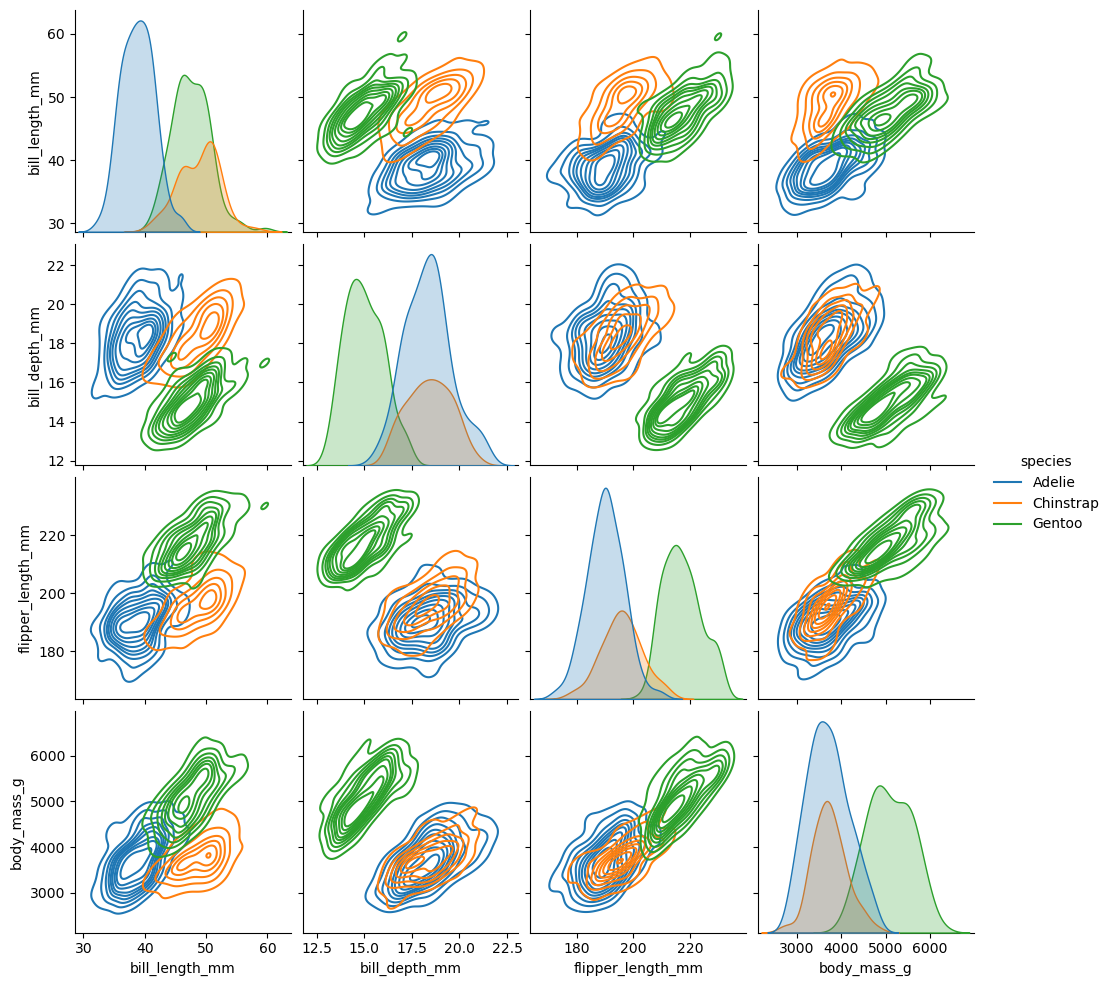

In [25]:
sns.pairplot(penguins[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'species']], hue='species', kind='kde')

We see that there is an awful lot of mixing going on for Adelie and Chinstrap penguins. For example, `body_mass_g` and other `bill_depth_mm` and `flipper_length_mm` don't work well.

Additionally, body_mass_g has a much larger number range than the other properties. This is bad because KNN works by looking at the closest neighbours. It does this by measuring distance between points. However, if one dimension has large numbers and the other small numbers, this will make the dimension with the larger numbers have an outsized effect on the distance.

For example, if you look at body_mass_g then 4000 and 4050 would be considered close-by with a difference of just 50. However, if you look at bill_depth_mm, then a difference of 50 is huge since that data only ranges from 12.5 to 22.5.

Therefore, it is usually a good idea to modify the scale of each column of the data such that all data columns are in similar ranges to prevent this sort of issue. This is called normalization. Sklearn comes with just such a tool, `MinMaxScaler`! It maps the data to a range between 0 and 1.

Let's implement that and do our training again.

In [27]:
X = penguins[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']]
y = penguins['species']

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=42)
neigh = KNeighborsClassifier(n_neighbors=4)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
accuracy_score(y_test, y_pred)

0.99

There we go! We now have 99% accuracy!

We still haven't used all of the data though. There are still the islands and the sex. However, those aren't numbers so how do you calculate distances there? It's maybe clear for sex since we have only female and male, so we could assign values of 0 and 1 to represent each sex.

In [29]:
penguins.sex = penguins.sex.replace({"Female": 0, "Male": 1})
penguins.head()

/var/folders/f5/phrkmd9n2s9c263s3g9bpzqh0000gn/T/ipykernel_9365/1235691974.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  penguins.sex = penguins.sex.replace({"Female": 0, "Male": 1})


species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
4  Adelie  Torgersen            36.7           19.3              193.0   
5  Adelie  Torgersen            39.3           20.6              190.0   

   body_mass_g  sex  
0       3750.0    1  
1       3800.0    0  
2       3250.0    0  
4       3450.0    0  
5       3650.0    1

But there are three islands in our dataset:

In [31]:
set(penguins['island'])

{'Biscoe', 'Dream', 'Torgersen'}

We could assign 0 to Biscoe, 1 to Dream and 2 to Torgersen, but that would make Biscoe and Torgersen "further" away from each other than Biscoe and Dream. That's not right.

One way around this is to use one-hot vectors. These are vectors that have all zeroes except for one entry which is one. Instead of assigning a number to an island, we assign a vector.

$$
Biscoe = \begin{bmatrix}
           1 \\
           0 \\
           0
         \end{bmatrix},
Dream = \begin{bmatrix}
           0 \\
           1 \\
           0
         \end{bmatrix},
Torgersen = \begin{bmatrix}
           0 \\
           0 \\
           1
         \end{bmatrix}
$$

This translates into using the island column to generate three separate columns, one for each island with either 0 or 1. The Pandas library can do this for us automatically using the `pd.get_dummies` method.

In [33]:
pd.get_dummies(penguins['island'])

Biscoe  Dream  Torgersen
0     False  False       True
1     False  False       True
2     False  False       True
4     False  False       True
5     False  False       True
..      ...    ...        ...
338    True  False      False
340    True  False      False
341    True  False      False
342    True  False      False
343    True  False      False

[333 rows x 3 columns]

It shows `True` and `False`, but that's the same as 1 and 0 for computers.

The next step is to take those columns and join them to the original dataset.

In [35]:
penguins = penguins.join(pd.get_dummies(penguins['island']))
penguins

species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0    Adelie  Torgersen            39.1           18.7              181.0   
1    Adelie  Torgersen            39.5           17.4              186.0   
2    Adelie  Torgersen            40.3           18.0              195.0   
4    Adelie  Torgersen            36.7           19.3              193.0   
5    Adelie  Torgersen            39.3           20.6              190.0   
..      ...        ...             ...            ...                ...   
338  Gentoo     Biscoe            47.2           13.7              214.0   
340  Gentoo     Biscoe            46.8           14.3              215.0   
341  Gentoo     Biscoe            50.4           15.7              222.0   
342  Gentoo     Biscoe            45.2           14.8              212.0   
343  Gentoo     Biscoe            49.9           16.1              213.0   

     body_mass_g  sex  Biscoe  Dream  Torgersen  
0         3750.0    1   False  False       True  
1         3800.0    0   False  False       True  
2         3250.0    0   False  False       True  
4         3450.0    0   False  False       True  
5         3650.0    1   False  False       True  
..           ...  ...     ...    ...        ...  
338       4925.0    0    True  False      False  
340       4850.0    0    True  False      False  
341       5750.0    1    True  False      False  
342       5200.0    0    True  False      False  
343       5400.0    1    True  False      False  

[333 rows x 10 columns]

Our data is now all numerical. Let's try our training again!

In [37]:
X = penguins[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex', 'Biscoe', 'Dream', 'Torgersen']]
y = penguins['species']

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=42)
neigh = KNeighborsClassifier(n_neighbors=4)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
accuracy_score(y_test, y_pred)

0.99

Well, our accuracy did not increase, but it's hard to beat 99% accuracy since our test data set only has 100 data rows. The model only got 1 wrong. Still, we are now using all of our features to train the model.

# CDC Dataset Example

Let's use a less clean dataset this time. The penguins dataset was cleaned up thoroughly beforehand. It did have some missing values, but we simply dropped those.

We'd like to note that the Pima Indians Diabetes Dataset is often used for machine learning and predictive modelling. The dataset originated from the National Institute of Diabetes and Digestive and Kidney Diseases, and it includes health data collected from an Indigenous population living in the Gila River Indian Community Reservation in Arizona. It has become the standard dataset for testing and training algorithms.

However, there are [serious ethical issues](https://www.journals.uchicago.edu/doi/full/10.1086/693853) with this dataset. The way the data were collected and have been shared do not follow best practices in [managing sensitive data](https://ecampusontario.pressbooks.pub/canadardm/chapter/sensitive-data-practical-and-theoretical-considerations/) and respecting [Indigenous data sovereignty](https://ecampusontario.pressbooks.pub/canadardm/chapter/indigenous-data-sovereignty/). The reservation was treated as a controlled laboratory environment and the results of the studies were not used to improve health care for members of the Community. The dataset was archived in the University of California, Irvine (UCI)’s Machine Learning Repository. Since then, different versions of the dataset have been made freely available for downloading and reuse without the consent of the studies’ participants or the Community. This is an important lesson in the need for [data transparency in AI](https://theodi.org/insights/reports/the-ai-data-transparency-index/).

For these reasons, we will not use the Pima dataset in our tutorial. Instead, we will use the CDC’s [2015 Behavioral Risk Factor Surveillance System (BRFSS) Survey Data](https://www.cdc.gov/brfss/annual_data/annual_2015.html). The BRFSS uses a phone survey to collect data on preventative health measures and risk behaviors that are associated with chronic diseases, injuries, and preventable infectious diseases impacting the adult population in the US.

## Downloading the data
Download the data from the CDC website and unzip it somewhere on your computer. The file to download is "2015 BRFSS Data (ASCII)" from https://www.cdc.gov/brfss/annual_data/annual_2015.html.

## Reading the data

The data uses a fixed width format, which means that columns in the dataset are always a fixed width. This also means that we need to specify all of the column lengths. Fortunately, there is a column specification that comes with the dataset. It's available in the Codebook which you will find at the same link as above. It specifies how wide each column is as one very big table.



### Column layout

The code below is the very same table but formatted as a Python dictionary so that we can work with it in Python. It is very long!

In [1]:
# Format is specified in https://www.cdc.gov/brfss/annual_data/2015/llcp_varlayout_15_onecolumn.html
collayout = [
    {"index":1,"name":"_STATE","length":2},
    {"index":17,"name":"FMONTH","length":2},
    {"index":19,"name":"IDATE","length":8},
    {"index":19,"name":"IMONTH","length":2},
    {"index":21,"name":"IDAY","length":2},
    {"index":23,"name":"IYEAR","length":4},
    {"index":32,"name":"DISPCODE","length":4},
    {"index":36,"name":"SEQNO","length":10},
    {"index":36,"name":"_PSU","length":10},
    {"index":63,"name":"CTELENUM","length":1},
    {"index":64,"name":"PVTRESD1","length":1},
    {"index":65,"name":"COLGHOUS","length":1},
    {"index":66,"name":"STATERES","length":1},
    {"index":67,"name":"CELLFON3","length":1},
    {"index":68,"name":"LADULT","length":1},
    {"index":69,"name":"NUMADULT","length":2},
    {"index":71,"name":"NUMMEN","length":2},
    {"index":73,"name":"NUMWOMEN","length":2},
    {"index":75,"name":"CTELNUM1","length":1},
    {"index":76,"name":"CELLFON2","length":1},
    {"index":77,"name":"CADULT","length":1},
    {"index":78,"name":"PVTRESD2","length":1},
    {"index":79,"name":"CCLGHOUS","length":1},
    {"index":80,"name":"CSTATE","length":1},
    {"index":83,"name":"LANDLINE","length":1},
    {"index":84,"name":"HHADULT","length":2},
    {"index":90,"name":"GENHLTH","length":1},
    {"index":91,"name":"PHYSHLTH","length":2},
    {"index":93,"name":"MENTHLTH","length":2},
    {"index":95,"name":"POORHLTH","length":2},
    {"index":97,"name":"HLTHPLN1","length":1},
    {"index":98,"name":"PERSDOC2","length":1},
    {"index":99,"name":"MEDCOST","length":1},
    {"index":100,"name":"CHECKUP1","length":1},
    {"index":101,"name":"BPHIGH4","length":1},
    {"index":102,"name":"BPMEDS","length":1},
    {"index":103,"name":"BLOODCHO","length":1},
    {"index":104,"name":"CHOLCHK","length":1},
    {"index":105,"name":"TOLDHI2","length":1},
    {"index":106,"name":"CVDINFR4","length":1},
    {"index":107,"name":"CVDCRHD4","length":1},
    {"index":108,"name":"CVDSTRK3","length":1},
    {"index":109,"name":"ASTHMA3","length":1},
    {"index":110,"name":"ASTHNOW","length":1},
    {"index":111,"name":"CHCSCNCR","length":1},
    {"index":112,"name":"CHCOCNCR","length":1},
    {"index":113,"name":"CHCCOPD1","length":1},
    {"index":114,"name":"HAVARTH3","length":1},
    {"index":115,"name":"ADDEPEV2","length":1},
    {"index":116,"name":"CHCKIDNY","length":1},
    {"index":117,"name":"DIABETE3","length":1},
    {"index":118,"name":"DIABAGE2","length":2},
    {"index":120,"name":"SEX","length":1},
    {"index":157,"name":"MARITAL","length":1},
    {"index":158,"name":"EDUCA","length":1},
    {"index":159,"name":"RENTHOM1","length":1},
    {"index":168,"name":"NUMHHOL2","length":1},
    {"index":169,"name":"NUMPHON2","length":1},
    {"index":170,"name":"CPDEMO1","length":1},
    {"index":171,"name":"VETERAN3","length":1},
    {"index":172,"name":"EMPLOY1","length":1},
    {"index":173,"name":"CHILDREN","length":2},
    {"index":175,"name":"INCOME2","length":2},
    {"index":177,"name":"INTERNET","length":1},
    {"index":178,"name":"WEIGHT2","length":4},
    {"index":182,"name":"HEIGHT3","length":4},
    {"index":186,"name":"PREGNANT","length":1},
    {"index":187,"name":"QLACTLM2","length":1},
    {"index":188,"name":"USEEQUIP","length":1},
    {"index":189,"name":"BLIND","length":1},
    {"index":190,"name":"DECIDE","length":1},
    {"index":191,"name":"DIFFWALK","length":1},
    {"index":192,"name":"DIFFDRES","length":1},
    {"index":193,"name":"DIFFALON","length":1},
    {"index":194,"name":"SMOKE100","length":1},
    {"index":195,"name":"SMOKDAY2","length":1},
    {"index":196,"name":"STOPSMK2","length":1},
    {"index":197,"name":"LASTSMK2","length":2},
    {"index":199,"name":"USENOW3","length":1},
    {"index":200,"name":"ALCDAY5","length":3},
    {"index":203,"name":"AVEDRNK2","length":2},
    {"index":205,"name":"DRNK3GE5","length":2},
    {"index":207,"name":"MAXDRNKS","length":2},
    {"index":209,"name":"FRUITJU1","length":3},
    {"index":212,"name":"FRUIT1","length":3},
    {"index":215,"name":"FVBEANS","length":3},
    {"index":218,"name":"FVGREEN","length":3},
    {"index":221,"name":"FVORANG","length":3},
    {"index":224,"name":"VEGETAB1","length":3},
    {"index":227,"name":"EXERANY2","length":1},
    {"index":228,"name":"EXRACT11","length":2},
    {"index":230,"name":"EXEROFT1","length":3},
    {"index":233,"name":"EXERHMM1","length":3},
    {"index":236,"name":"EXRACT21","length":2},
    {"index":238,"name":"EXEROFT2","length":3},
    {"index":241,"name":"EXERHMM2","length":3},
    {"index":244,"name":"STRENGTH","length":3},
    {"index":247,"name":"LMTJOIN3","length":1},
    {"index":248,"name":"ARTHDIS2","length":1},
    {"index":249,"name":"ARTHSOCL","length":1},
    {"index":250,"name":"JOINPAIN","length":2},
    {"index":252,"name":"SEATBELT","length":1},
    {"index":253,"name":"FLUSHOT6","length":1},
    {"index":254,"name":"FLSHTMY2","length":6},
    {"index":260,"name":"IMFVPLAC","length":2},
    {"index":262,"name":"PNEUVAC3","length":1},
    {"index":263,"name":"HIVTST6","length":1},
    {"index":264,"name":"HIVTSTD3","length":6},
    {"index":270,"name":"WHRTST10","length":2},
    {"index":287,"name":"PDIABTST","length":1},
    {"index":288,"name":"PREDIAB1","length":1},
    {"index":289,"name":"INSULIN","length":1},
    {"index":290,"name":"BLDSUGAR","length":3},
    {"index":293,"name":"FEETCHK2","length":3},
    {"index":296,"name":"DOCTDIAB","length":2},
    {"index":298,"name":"CHKHEMO3","length":2},
    {"index":300,"name":"FEETCHK","length":2},
    {"index":302,"name":"EYEEXAM","length":1},
    {"index":303,"name":"DIABEYE","length":1},
    {"index":304,"name":"DIABEDU","length":1},
    {"index":305,"name":"PAINACT2","length":2},
    {"index":307,"name":"QLMENTL2","length":2},
    {"index":309,"name":"QLSTRES2","length":2},
    {"index":311,"name":"QLHLTH2","length":2},
    {"index":313,"name":"CAREGIV1","length":1},
    {"index":314,"name":"CRGVREL1","length":2},
    {"index":316,"name":"CRGVLNG1","length":1},
    {"index":317,"name":"CRGVHRS1","length":1},
    {"index":318,"name":"CRGVPRB1","length":2},
    {"index":320,"name":"CRGVPERS","length":1},
    {"index":321,"name":"CRGVHOUS","length":1},
    {"index":322,"name":"CRGVMST2","length":1},
    {"index":323,"name":"CRGVEXPT","length":1},
    {"index":324,"name":"VIDFCLT2","length":1},
    {"index":325,"name":"VIREDIF3","length":1},
    {"index":326,"name":"VIPRFVS2","length":1},
    {"index":327,"name":"VINOCRE2","length":2},
    {"index":329,"name":"VIEYEXM2","length":1},
    {"index":330,"name":"VIINSUR2","length":1},
    {"index":331,"name":"VICTRCT4","length":1},
    {"index":332,"name":"VIGLUMA2","length":1},
    {"index":333,"name":"VIMACDG2","length":1},
    {"index":334,"name":"CIMEMLOS","length":1},
    {"index":335,"name":"CDHOUSE","length":1},
    {"index":336,"name":"CDASSIST","length":1},
    {"index":337,"name":"CDHELP","length":1},
    {"index":338,"name":"CDSOCIAL","length":1},
    {"index":339,"name":"CDDISCUS","length":1},
    {"index":340,"name":"WTCHSALT","length":1},
    {"index":341,"name":"LONGWTCH","length":3},
    {"index":344,"name":"DRADVISE","length":1},
    {"index":345,"name":"ASTHMAGE","length":2},
    {"index":347,"name":"ASATTACK","length":1},
    {"index":348,"name":"ASERVIST","length":2},
    {"index":350,"name":"ASDRVIST","length":2},
    {"index":352,"name":"ASRCHKUP","length":2},
    {"index":354,"name":"ASACTLIM","length":3},
    {"index":357,"name":"ASYMPTOM","length":1},
    {"index":358,"name":"ASNOSLEP","length":1},
    {"index":359,"name":"ASTHMED3","length":1},
    {"index":360,"name":"ASINHALR","length":1},
    {"index":361,"name":"HAREHAB1","length":1},
    {"index":362,"name":"STREHAB1","length":1},
    {"index":363,"name":"CVDASPRN","length":1},
    {"index":364,"name":"ASPUNSAF","length":1},
    {"index":365,"name":"RLIVPAIN","length":1},
    {"index":366,"name":"RDUCHART","length":1},
    {"index":367,"name":"RDUCSTRK","length":1},
    {"index":368,"name":"ARTTODAY","length":1},
    {"index":369,"name":"ARTHWGT","length":1},
    {"index":370,"name":"ARTHEXER","length":1},
    {"index":371,"name":"ARTHEDU","length":1},
    {"index":372,"name":"TETANUS","length":1},
    {"index":373,"name":"HPVADVC2","length":1},
    {"index":374,"name":"HPVADSHT","length":2},
    {"index":376,"name":"SHINGLE2","length":1},
    {"index":377,"name":"HADMAM","length":1},
    {"index":378,"name":"HOWLONG","length":1},
    {"index":379,"name":"HADPAP2","length":1},
    {"index":380,"name":"LASTPAP2","length":1},
    {"index":381,"name":"HPVTEST","length":1},
    {"index":382,"name":"HPLSTTST","length":1},
    {"index":383,"name":"HADHYST2","length":1},
    {"index":384,"name":"PROFEXAM","length":1},
    {"index":385,"name":"LENGEXAM","length":1},
    {"index":386,"name":"BLDSTOOL","length":1},
    {"index":387,"name":"LSTBLDS3","length":1},
    {"index":388,"name":"HADSIGM3","length":1},
    {"index":389,"name":"HADSGCO1","length":1},
    {"index":390,"name":"LASTSIG3","length":1},
    {"index":391,"name":"PCPSAAD2","length":1},
    {"index":392,"name":"PCPSADI1","length":1},
    {"index":393,"name":"PCPSARE1","length":1},
    {"index":394,"name":"PSATEST1","length":1},
    {"index":395,"name":"PSATIME","length":1},
    {"index":396,"name":"PCPSARS1","length":1},
    {"index":397,"name":"PCPSADE1","length":1},
    {"index":398,"name":"PCDMDECN","length":4},
    {"index":602,"name":"SCNTMNY1","length":1},
    {"index":603,"name":"SCNTMEL1","length":1},
    {"index":604,"name":"SCNTPAID","length":1},
    {"index":605,"name":"SCNTWRK1","length":2},
    {"index":607,"name":"SCNTLPAD","length":1},
    {"index":608,"name":"SCNTLWK1","length":2},
    {"index":610,"name":"SXORIENT","length":1},
    {"index":611,"name":"TRNSGNDR","length":1},
    {"index":618,"name":"RCSGENDR","length":1},
    {"index":655,"name":"RCSRLTN2","length":1},
    {"index":656,"name":"CASTHDX2","length":1},
    {"index":657,"name":"CASTHNO2","length":1},
    {"index":658,"name":"EMTSUPRT","length":1},
    {"index":659,"name":"LSATISFY","length":1},
    {"index":660,"name":"ADPLEASR","length":2},
    {"index":662,"name":"ADDOWN","length":2},
    {"index":664,"name":"ADSLEEP","length":2},
    {"index":666,"name":"ADENERGY","length":2},
    {"index":668,"name":"ADEAT1","length":2},
    {"index":670,"name":"ADFAIL","length":2},
    {"index":672,"name":"ADTHINK","length":2},
    {"index":674,"name":"ADMOVE","length":2},
    {"index":676,"name":"MISTMNT","length":1},
    {"index":677,"name":"ADANXEV","length":1},
    {"index":682,"name":"QSTVER","length":2},
    {"index":684,"name":"QSTLANG","length":2},
    {"index":841,"name":"EXACTOT1","length":20},
    {"index":861,"name":"EXACTOT2","length":20},
    {"index":1407,"name":"_STSTR","length":6},
    {"index":1413,"name":"_STRWT","length":10},
    {"index":1443,"name":"_RAWRAKE","length":10},
    {"index":1453,"name":"_WT2RAKE","length":10},
    {"index":1478,"name":"_CHISPNC","length":1},
    {"index":1535,"name":"_CRACE1","length":2},
    {"index":1537,"name":"_CPRACE","length":2},
    {"index":1605,"name":"_CLCWTV1","length":10},
    {"index":1677,"name":"_DUALUSE","length":1},
    {"index":1678,"name":"_DUALCOR","length":10},
    {"index":1792,"name":"_LCPWTV1","length":10},
    {"index":1894,"name":"_RFHLTH","length":1},
    {"index":1895,"name":"_HCVU651","length":1},
    {"index":1896,"name":"_RFHYPE5","length":1},
    {"index":1897,"name":"_CHOLCHK","length":1},
    {"index":1898,"name":"_RFCHOL","length":1},
    {"index":1899,"name":"_MICHD","length":1},
    {"index":1900,"name":"_LTASTH1","length":1},
    {"index":1901,"name":"_CASTHM1","length":1},
    {"index":1902,"name":"_ASTHMS1","length":1},
    {"index":1903,"name":"_DRDXAR1","length":1},
    {"index":1960,"name":"_PRACE1","length":2},
    {"index":1962,"name":"_MRACE1","length":2},
    {"index":1966,"name":"_HISPANC","length":1},
    {"index":1967,"name":"_RACE","length":1},
    {"index":1968,"name":"_RACEG21","length":1},
    {"index":1969,"name":"_RACEGR3","length":1},
    {"index":1970,"name":"_RACE_G1","length":1},
    {"index":1971,"name":"_AGEG5YR","length":2},
    {"index":1973,"name":"_AGE65YR","length":1},
    {"index":1974,"name":"_AGE80","length":2},
    {"index":1976,"name":"_AGE_G","length":1},
    {"index":1977,"name":"HTIN4","length":3},
    {"index":1980,"name":"HTM4","length":3},
    {"index":1983,"name":"WTKG3","length":5},
    {"index":1988,"name":"_BMI5","length":4},
    {"index":1992,"name":"_BMI5CAT","length":1},
    {"index":1993,"name":"_RFBMI5","length":1},
    {"index":1994,"name":"_CHLDCNT","length":1},
    {"index":1995,"name":"_EDUCAG","length":1},
    {"index":1996,"name":"_INCOMG","length":1},
    {"index":1997,"name":"_SMOKER3","length":1},
    {"index":1998,"name":"_RFSMOK3","length":1},
    {"index":1999,"name":"DRNKANY5","length":1},
    {"index":2000,"name":"DROCDY3_","length":3},
    {"index":2003,"name":"_RFBING5","length":1},
    {"index":2004,"name":"_DRNKWEK","length":5},
    {"index":2009,"name":"_RFDRHV5","length":1},
    {"index":2010,"name":"FTJUDA1_","length":4},
    {"index":2014,"name":"FRUTDA1_","length":4},
    {"index":2018,"name":"BEANDAY_","length":4},
    {"index":2022,"name":"GRENDAY_","length":4},
    {"index":2026,"name":"ORNGDAY_","length":4},
    {"index":2030,"name":"VEGEDA1_","length":4},
    {"index":2034,"name":"_MISFRTN","length":1},
    {"index":2035,"name":"_MISVEGN","length":1},
    {"index":2036,"name":"_FRTRESP","length":1},
    {"index":2037,"name":"_VEGRESP","length":1},
    {"index":2038,"name":"_FRUTSUM","length":6},
    {"index":2044,"name":"_VEGESUM","length":6},
    {"index":2050,"name":"_FRTLT1","length":1},
    {"index":2051,"name":"_VEGLT1","length":1},
    {"index":2052,"name":"_FRT16","length":1},
    {"index":2053,"name":"_VEG23","length":1},
    {"index":2054,"name":"_FRUITEX","length":1},
    {"index":2055,"name":"_VEGETEX","length":1},
    {"index":2058,"name":"_TOTINDA","length":1},
    {"index":2059,"name":"METVL11_","length":3},
    {"index":2062,"name":"METVL21_","length":3},
    {"index":2065,"name":"MAXVO2_","length":5},
    {"index":2070,"name":"FC60_","length":5},
    {"index":2075,"name":"ACTIN11_","length":1},
    {"index":2076,"name":"ACTIN21_","length":1},
    {"index":2077,"name":"PADUR1_","length":3},
    {"index":2080,"name":"PADUR2_","length":3},
    {"index":2083,"name":"PAFREQ1_","length":5},
    {"index":2088,"name":"PAFREQ2_","length":5},
    {"index":2093,"name":"_MINAC11","length":5},
    {"index":2098,"name":"_MINAC21","length":5},
    {"index":2103,"name":"STRFREQ_","length":5},
    {"index":2108,"name":"PAMISS1_","length":1},
    {"index":2109,"name":"PAMIN11_","length":5},
    {"index":2114,"name":"PAMIN21_","length":5},
    {"index":2119,"name":"PA1MIN_","length":5},
    {"index":2124,"name":"PAVIG11_","length":5},
    {"index":2129,"name":"PAVIG21_","length":5},
    {"index":2134,"name":"PA1VIGM_","length":5},
    {"index":2139,"name":"_PACAT1","length":1},
    {"index":2140,"name":"_PAINDX1","length":1},
    {"index":2141,"name":"_PA150R2","length":1},
    {"index":2142,"name":"_PA300R2","length":1},
    {"index":2143,"name":"_PA30021","length":1},
    {"index":2144,"name":"_PASTRNG","length":1},
    {"index":2145,"name":"_PAREC1","length":1},
    {"index":2146,"name":"_PASTAE1","length":1},
    {"index":2147,"name":"_LMTACT1","length":1},
    {"index":2148,"name":"_LMTWRK1","length":1},
    {"index":2149,"name":"_LMTSCL1","length":1},
    {"index":2150,"name":"_RFSEAT2","length":1},
    {"index":2151,"name":"_RFSEAT3","length":1},
    {"index":2152,"name":"_FLSHOT6","length":1},
    {"index":2153,"name":"_PNEUMO2","length":1},
    {"index":2154,"name":"_AIDTST3","length":1},
]

# Take this column layout an convert it into column names and column specifications for Pandas to use.
colnames = [row["name"] for row in collayout]
colspecs = [(row["index"]-1, row["index"]-1+row["length"]) for row in collayout]

### Loading the data as a DataFrame

We can now proceed to use the Pandas functions for loading data into a DataFrame. For fixed width formats, the function is called `read_fwf`. You will need to update the path below to wherever you extracted the data to earlier. The parameter `colspecs` specifies the index and length of each column while `names` specifies the column names. This all comes from the large code block we generated from the Codebook.

In [3]:
diabetesdata = pd.read_fwf("/home/jvanderk/Downloads/LLCP2015.ASC", colspecs=colspecs, header=None, names=colnames, dtype=str)

This contains way too much data. We want to investigate diabetes, so we'll trim the data to the columns that represent the variables we think are relevant. To be able to do that, we need to know what all these column or variable names mean. For example, what does "_AGEG5YR" mean? Fortunately, we can use the [Codebook](https://www.cdc.gov/brfss/annual_data/2015/pdf/codebook15_llcp.pdf) that is provided along with the data and look up the variable names.

The variable name "_AGEG5YR" means age group in brackets of 5 years. It's coded as a number from 1 to 14 that corresponds to various age groups. The number 1 means age 18 to 24; number 2 means age 25 to 29; and so on.

There are also some conversion tables. For example, "HEIGHT3" is the height of a person but the response can be both imperial or metric. Imperial is also given in a single number that has both feet and inches in it. To get this sort of data, we'll need to build conversion functions.

Let's do this for height and weight.

In [4]:
def cdc_to_centimeter(input):
    # Convert the input to a height in centimeters
    if len(input) != 4:
        return np.nan

    if input[0] == '0':
        # Feet/inch
        feet = int(input[1])
        inch = int(input[2:4])
        return int(30.48*feet + 2.54*inch)
    elif input[0] == '7':
        # Don't know
        return np.nan
    elif input == "9999":
        # Refused
        return np.nan
    elif input[0] == '9':
        # Centimetres
        return int(input[1:4])
    else:
        return np.nan

def cdc_to_kilogram(input):
    # Convert the input to a weight in kilograms
    if len(input) != 4:
        return np.nan

    if input[0] == '0':
        pounds = int(input[1:4])
        return int(0.4535924*pounds)
    elif input[0] == '7':
        return np.nan
    elif input == "9999":
        # Refused
        return np.nan
    elif input[0] == '9':
        return int(input[1:4])
    else:
        return np.nan

Then map this function to the HEIGHT3 column and convert it to integers while preserving missing values (NaN).

In [5]:
diabetesdata["HEIGHT3"] = diabetesdata["HEIGHT3"].map(cdc_to_centimeter, na_action='ignore').astype("Int64")
diabetesdata["WEIGHT2"] = diabetesdata["WEIGHT2"].map(cdc_to_kilogram, na_action='ignore').astype("Int64")

Height and weight on their own are not very interesting as an indicator but BMI is since it's correlated to obesity. So we need a function to create a new column for BMI.

In [6]:
def cdc_to_bmi(height, weight):
    return  weight / (height/100.)**2

In [7]:
diabetesdata["BMI"] = diabetesdata.apply(lambda row : cdc_to_bmi(row["HEIGHT3"], row["WEIGHT2"]), axis=1).astype("Float64")

Finally, we should focus on just a few columns. There is a lot of data here but most of it will not be related to diabetes. So we can pick a few that we think might be relevant. The keyword here being "think" since it's just intuition at this point. One might be tempted to use all the columns and let the machine learning algorithm figure it out, but this would be bad idea, especially for KNN, because it doesn't scale well with too many columns. We will explain this in more detail later.

In [8]:
diabetesdata = diabetesdata[['BPHIGH4', "_AGEG5YR", "BMI", "SEX", "GENHLTH", "TOLDHI2", "INCOME2", "SMOKE100", "VIREDIF3", "DIABETE3"]]

In [9]:
diabetesdata

BPHIGH4 _AGEG5YR        BMI SEX GENHLTH TOLDHI2 INCOME2 SMOKE100  \
0            1       09  40.537521   2       5       1      03        1   
1            3       07  25.013521   2       3       2      01        1   
2            3       11   21.91358   2       4       1      99      NaN   
3            1       09  28.027682   2       5       1      08        2   
4            3       09  24.386526   2       5       2      77        2   
...        ...      ...        ...  ..     ...     ...     ...      ...   
441451       1       11  18.359375   2       4       1      04        2   
441452       3       02     28.125   2       1       2      02        2   
441453       1       11  41.138659   2       4       1      05        1   
441454       1       07  23.148148   1       3       2      01        2   
441455       1       09  24.747454   2       2       1      02        2   

       VIREDIF3 DIABETE3  
0           NaN        3  
1           NaN        3  
2           NaN        3  
3           NaN        3  
4           NaN        3  
...         ...      ...  
441451      NaN        1  
441452      NaN        3  
441453      NaN        3  
441454      NaN        3  
441455      NaN        1  

[441456 rows x 10 columns]

## Decoding survey data
There are still quite a few columns that are coded. We need to refer to the [Codebook](https://www.cdc.gov/brfss/annual_data/2015/pdf/codebook15_llcp.pdf) again to decipher the codes and make a judgement on which columns we want to use.
### BPHIGH4
This variable represents a survey question asking the participant if they have ever been told they have high blood pressure. Codes 1 and 2 mean "yes", with 2 being a special case involving pregnancy. Code 3 means "no", while code 4 means "close to high". 7 means they "don't know" and 9 means they refused to give an answer. So we can convert this data into something more sensical for the model. We may want to assume that not being told about high blood pressure means that those survey participants don't have high blood pressure even though people could have high blood pressure, but they simply haven't been told they do.

With that in mind, we can use 0 for "no", 1 for "borderline high", and 2 for "high". All the rest we can take as NaN (Not a Number, i.e. missing value). We will follow a similar pattern for all of the functions below.

In [10]:
def cdc_high_blood_pressure(input):
    if input == "1" or input == "2":
        return 2
    elif input == "3":
        return 0
    elif input == "4":
        return 1
    else:
        return np.nan

### _AGEG5YR
These are the 5-year age groups, starting at the age of 18. We could convert this to an actual age range, but it's already nice and linear, so we can just keep it like that. The only exception is code 14 which means "Don’t know/Refused/Missing".

In [11]:
def cdc_age_groups(input):
    # All data is read as a string, so convert it into a number first
    agegroup = int(input)
    if agegroup > 0 and agegroup <= 13:
        return agegroup
    else:
        return np.nan

### SEX
This is only 1 for "male" or 2 for "female". So we can leave that as is.

### GENHLTH
This is a rating on a scale from 1 to 5 with 1 being "Excellent" and 5 being "Poor". There are also codes 7 and 9 which means "don't know" and "refused", so we can convert those to NaN.

In [12]:
def cdc_general_health(input):
    # All data is read as a string, so convert it into a number first
    genhealth = int(input)
    if genhealth > 0 and genhealth <= 5:
        return genhealth
    else:
        return np.nan

### TOLDHI2

This variable means if the particpant has ever been told they have high cholesterol where 1 is "yes" and 2 is "no". 7 and 9 mean "don't know" and "refused".

In [13]:
def cdc_cholesterol(input):
    if input == "1":
        return 1
    elif input == "2":
        return 0
    else:
        return np.nan

### INCOME2
This is the variable for annual household income. Again, it's measured on a linear scale from 1 to 8. We have codes 77 and 99 for "don't know" and "refused".

In [14]:
def cdc_income(input):
    incomegroup = int(input)
    if incomegroup > 0 and incomegroup <= 8:
        return incomegroup
    else:
        return np.nan

### SMOKE100
If they smoked more than 100 cigarettes in their lifetime. 1 means "yes", 2 means "no". The rest is "unknown" or "refused".

In [15]:
def cdc_smoke(input):
    if input == "1":
        return 1
    elif input == "2":
        return 0
    else:
        return np.nan

### VIREDIF3
This stands for "Visual Impairment and Access to Eye Care" and the survey question asks about the ability to read print materials and numbers on the phone. Since diabetes may impact eyesight, this is maybe a good variable to include. The values are on a scale from 1 to 5 where 1 is "no difficulty" and 5 is "unable to do because of eyesight". The other codes, we can treat as NaN again.

In [16]:
def cdc_vision(input):
    vision = int(input)
    if vision > 0 and vision <= 5:
        return vision
    else:
        return np.nan

### DIABETE3
Finally, we have the variable we are most interested in because this indicates if people have diabetes, which is what we want to try and predict using the KNN model. According to the Codebook, it's actually a scale. Options 1 and 2 both mean "yes", where 2 means "only during pregnency". Code 3 means "no", but 4 means "pre-diabetes/borderline". Now we have to ask ourselves, do we include that as a scale of sorts? That is, use 0 to mean "no diabetes", 1 be "a little bit", and 2 be "yes"? This might make it harder to classify since we now have three options to predict. We can also not use a scale and just have a yes/no answer, but then does "pre-diabetes/borderline" count as "no diabetes"? Or do we include it as "yes"?

There is no clear right or wrong answer to this; you need to be a subject matter expert to make the call. Here, we will make things easier for ourselves and count pre-diabetes/borderline as not having diabetes.

In [17]:
def cdc_diabetes(input):
    if input == "1" or input == "2":
        return 1
    elif input == "3" or input == "4":
        return 0
    else:
        return np.nan

We now have proper conversion functions for all of the columns in our data subset. We still need to apply them though. So, same as before:

In [18]:
diabetesdata["BPHIGH4"]=diabetesdata["BPHIGH4"].map(cdc_high_blood_pressure, na_action='ignore').astype("Int64")
diabetesdata["_AGEG5YR"] = diabetesdata["_AGEG5YR"].map(cdc_age_groups, na_action='ignore').astype("Int64")
diabetesdata["GENHLTH"] = diabetesdata["GENHLTH"].map(cdc_general_health, na_action='ignore').astype("Int64")
diabetesdata["TOLDHI2"] = diabetesdata["TOLDHI2"].map(cdc_cholesterol, na_action='ignore').astype("Float64")
diabetesdata["INCOME2"] = diabetesdata["INCOME2"].map(cdc_income, na_action='ignore').astype("Float64")
diabetesdata["SMOKE100"] = diabetesdata["SMOKE100"].map(cdc_smoke, na_action='ignore').astype("Int64")
diabetesdata["VIREDIF3"] = diabetesdata["VIREDIF3"].map(cdc_vision, na_action='ignore').astype("Int64")
diabetesdata["DIABETE3"] = diabetesdata["DIABETE3"].map(cdc_diabetes, na_action='ignore').astype("Int64")

In [19]:
diabetesdata

BPHIGH4  _AGEG5YR        BMI SEX  GENHLTH  TOLDHI2  INCOME2  SMOKE100  \
0             2         9  40.537521   2        5      1.0      3.0         1   
1             0         7  25.013521   2        3      0.0      1.0         1   
2             0        11   21.91358   2        4      1.0     <NA>      <NA>   
3             2         9  28.027682   2        5      1.0      8.0         0   
4             0         9  24.386526   2        5      0.0     <NA>         0   
...         ...       ...        ...  ..      ...      ...      ...       ...   
441451        2        11  18.359375   2        4      1.0      4.0         0   
441452        0         2     28.125   2        1      0.0      2.0         0   
441453        2        11  41.138659   2        4      1.0      5.0         1   
441454        2         7  23.148148   1        3      0.0      1.0         0   
441455        2         9  24.747454   2        2      1.0      2.0         0   

        VIREDIF3  DIABETE3  
0           <NA>         0  
1           <NA>         0  
2           <NA>         0  
3           <NA>         0  
4           <NA>         0  
...          ...       ...  
441451      <NA>         1  
441452      <NA>         0  
441453      <NA>         0  
441454      <NA>         0  
441455      <NA>         1  

[441456 rows x 10 columns]

## Cleaning the data
Now that we have all the data in a format we can use, we can start looking at the data quality. That is, we want to know how complete our data is. The handy function `.info()` will help us with that.

In [20]:
diabetesdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 441456 entries, 0 to 441455
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   BPHIGH4   440089 non-null  Int64  
 1   _AGEG5YR  436120 non-null  Int64  
 2   BMI       407369 non-null  Float64
 3   SEX       441456 non-null  object 
 4   GENHLTH   440209 non-null  Int64  
 5   TOLDHI2   378741 non-null  Float64
 6   INCOME2   361951 non-null  Float64
 7   SMOKE100  423907 non-null  Int64  
 8   VIREDIF3  3160 non-null    Int64  
 9   DIABETE3  440658 non-null  Int64  
dtypes: Float64(3), Int64(6), object(1)
memory usage: 37.5+ MB


We can see that we have 443,456 rows. Most of the columns have values except for the column "VIREDIF3" which only has 3160 values! This column was the question about visual impairment.

Why would we be missing so many values there? If we again look at the [Codebook](https://www.cdc.gov/brfss/annual_data/2015/pdf/codebook15_llcp.pdf), we see that there was actually a note. This question was not asked to people younger than 40 or if VIDFCLT2 was not applicable (recognizing people across the street). This goes to show it pays off to read the Codebook in detail! So we will not be using that column. We will drop it:

In [21]:
diabetesdata.drop("VIREDIF3", axis=1, inplace=True)

There are still columns that have missing data points, but we will worry about those later. First, let's look at the pair plot again. KNN likes very distinct regions. Let's see if we can spot any! There are, however, many data points and it would be very slow to make the pairplot. We can speed things up by looking at a sample of just 1,000 of the data rows instead of the whole dataset.

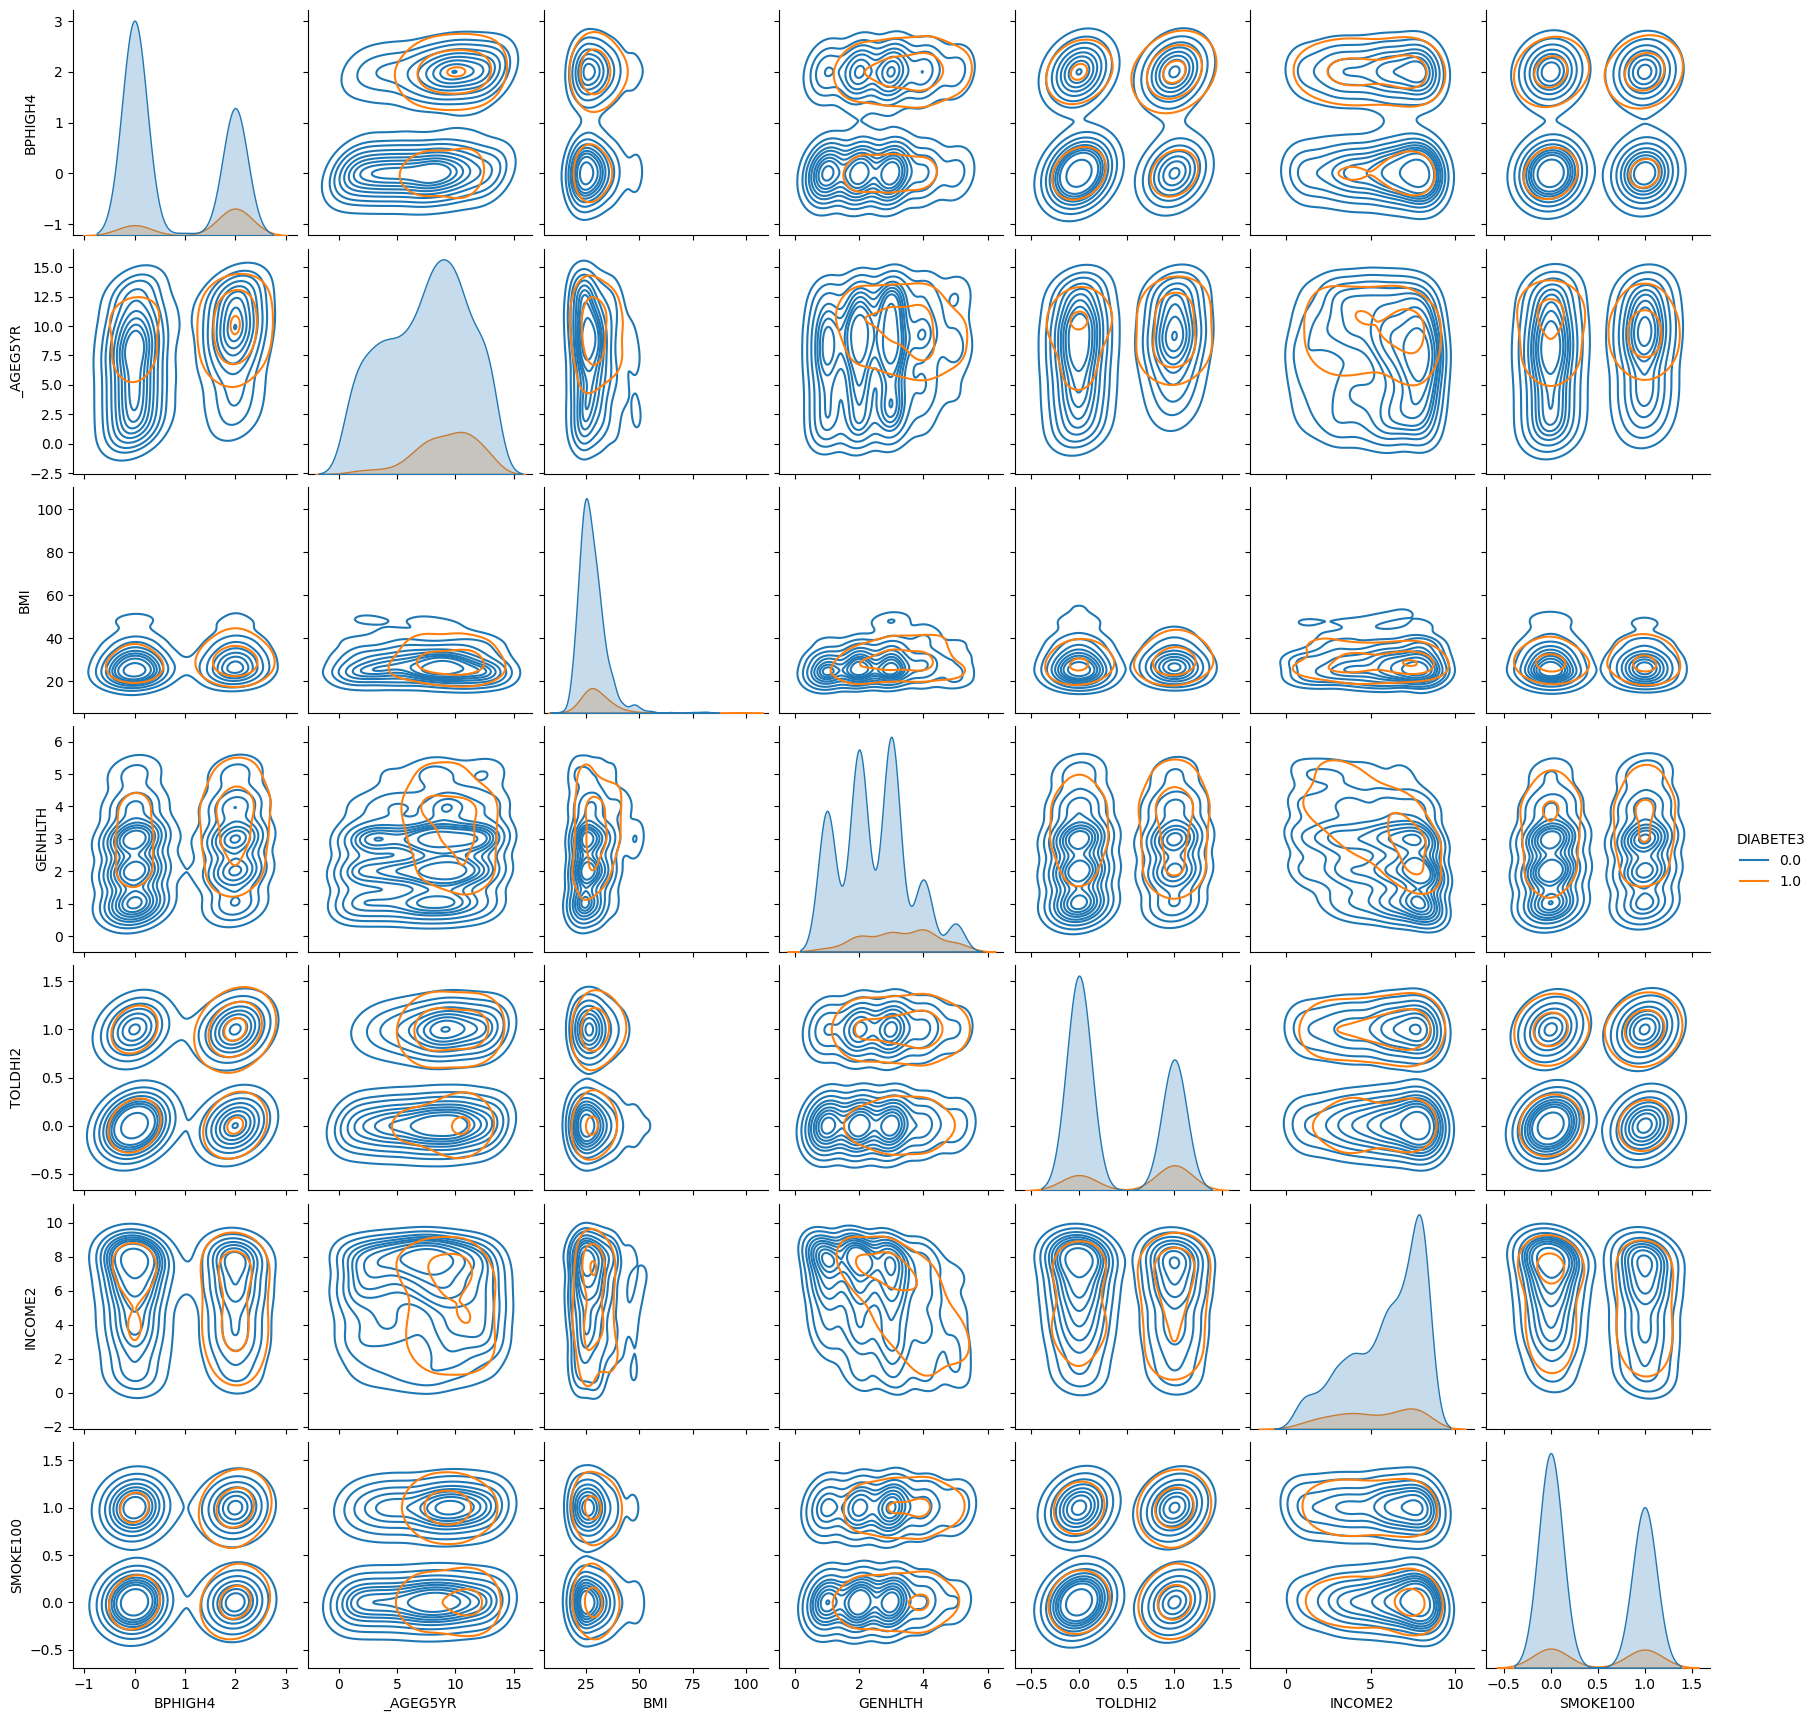

In [22]:
sns.pairplot(diabetesdata.sample(n=1000, random_state=42), hue='DIABETE3', kind='kde')

Well, that's not great. All of the blobs are overlapping while KNN works best when there are distinct blobs. No need to fear yet! We are only looking at one feature vs one other feature in each pair of this pair plot. There could still very well be distinct blobs in the full 6D space.

For example, in the image below we see a lot of overlap when considering only two axes, but if we look at the 3D view we can see there is no overlap at all.

![The left shows overlapping point while the right shows a 3D view where things do not overlap](../data/overlapping.png)

So pair plots are great for confirming that KNN might work but not for confirming that KNN will not work. We'll just go ahead.

First, we'll need to do something about the missing values (NaN). We could just drop them and we would still have plenty of data points available. KNN does not need that many anyway. However, for educational purposes, we do some more data cleaning. We will however drop the rows for which DIABETE3 is unknown. That's the thing we want to predict, so it better be there!

In [23]:
diabetesdata.dropna(subset="DIABETE3", inplace=True)

A thing we can do when we have missing data is impute, which means to try to fill in data for missing values based on intuition or statistical properties. It's basically guessing with style.

We can start with the features that have the least missing values. Those are easier to impute because you already have a lot of information from the existing points, so you may be able to infer what the missing value should have been. The next two columns that have the least amount of data are INCOME2 (361,951 data points for income group) and TOLDHI2 (378,741 data points for high blood pressure). All the other columns have over 400,000 data points and for those it would not be worth the effort of imputing. So will just drop the rows that have missing values in those columns.

In [24]:
diabetesdata.dropna(subset=["BPHIGH4","_AGEG5YR","BMI","SEX","GENHLTH","SMOKE100"], inplace=True)

In [25]:
diabetesdata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 393525 entries, 0 to 441455
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   BPHIGH4   393525 non-null  Int64  
 1   _AGEG5YR  393525 non-null  Int64  
 2   BMI       393525 non-null  Float64
 3   SEX       393525 non-null  object 
 4   GENHLTH   393525 non-null  Int64  
 5   TOLDHI2   339202 non-null  Float64
 6   INCOME2   335757 non-null  Float64
 7   SMOKE100  393525 non-null  Int64  
 8   DIABETE3  393525 non-null  Int64  
dtypes: Float64(3), Int64(5), object(1)
memory usage: 33.0+ MB


Returning to INCOME2 and TOLDHI2, let's see what their distributions looks like. We can use histograms for that.

array([[<Axes: title={'center': 'INCOME2'}>]], dtype=object)

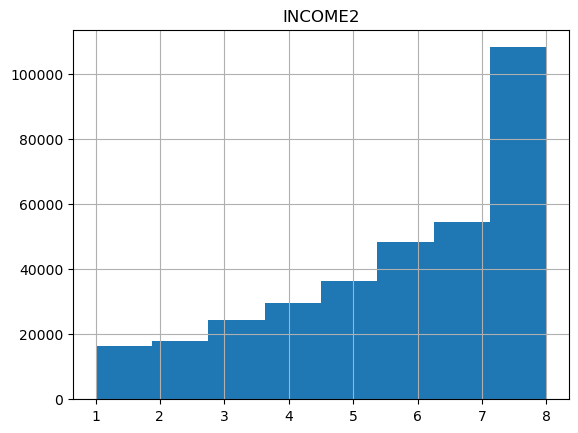

In [26]:
diabetesdata.hist('INCOME2', bins=8)

array([[<Axes: title={'center': 'TOLDHI2'}>]], dtype=object)

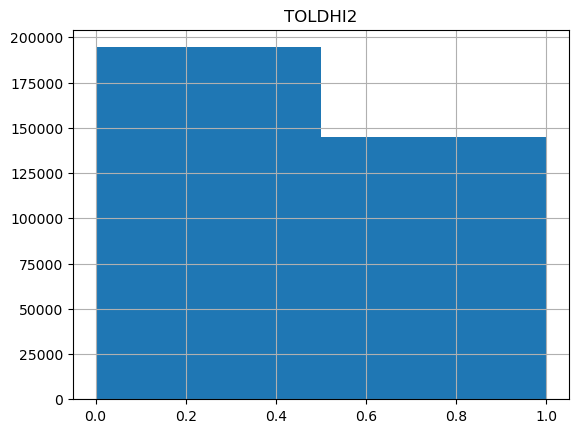

In [27]:
diabetesdata.hist('TOLDHI2', bins=2)

INCOME2 is nicely linear except for the final bin which corresponds to "US$75,000 or more" according to the Codebook. It seems the survey people could have used an extra bin in retrospect! Meanwhile, TOLDHI2 is pretty evenly distributed.

So what can we do here? Since there are only two answers for TOLDHI2, "yes" and "no", which we have a value of 1 and 0. So for each missing value, we technically have two options. However, there is nothing to prevent us from taking the mean. Since KNN is a machine learning model based on distance to its neighbours, we don't need to stick with whole numbers.

In [28]:
diabetesdata['TOLDHI2'] = diabetesdata['TOLDHI2'].fillna(diabetesdata['TOLDHI2'].mean())

For income, we have a lot more options. We have 8 distinct groups, but again, we can fill missing values with whatever we like. The mean isn't a good choice here, since the histogram is pretty spread out. There's no single peak.

We could use the histogram as a probability distribution and randomly generate numbers based on that. For example, we pick a number between 1 and 8 where the odds of picking an 8 is six times as likely as picking 1 as you can see in the histogram. We do this for every missing value. Filling missing values using this method has the advantage of not distorting the income distribution of the imputed dataset.

However, we can likely do better than that! If there is a relation between INCOME2 and any of the other columns we have, we may be able to infer what the income would be. If we look at the pairplot again, there seems to be a slight relation between INCOME2 and GENHLTH (general health). Let's plot a linear regression. We add a bit of jitter, which moves the points up or down and left or right by a small amount. Otherwise, the points will all be on top of each other.

<Axes: xlabel='GENHLTH', ylabel='INCOME2'>

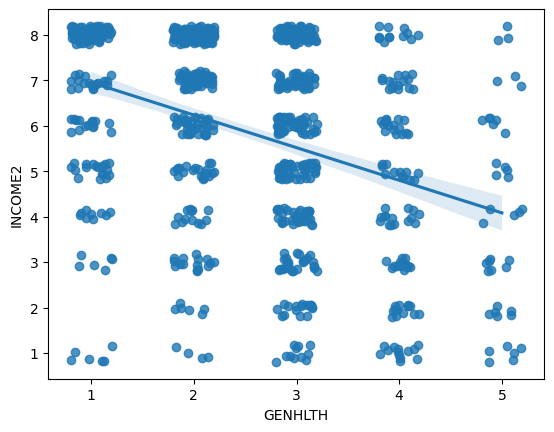

In [29]:
sns.regplot(x = 'GENHLTH', y = 'INCOME2', data = diabetesdata.sample(n=1000, random_state=42), x_jitter=0.2, y_jitter=0.2)

It's not entirely clear, but there seems to be some relation. Let's use a linear regression to estimate values. We are using machine learning to impute so we can do better machine learning!

Let's drop the missing values from INCOME2, then we can do the regression using the remaining data. We create a new variable, `linearregressiondata`, to store our data specifically for creating a linear regression model that we can then use with the original dataset to fill in the missing data.

In [30]:
linearregressiondata = diabetesdata.dropna(subset='INCOME2')

Then have Scikit Learn perform the linear regression

In [31]:
linregcolumns = ["GENHLTH"]
from sklearn.linear_model import LinearRegression
model = LinearRegression()
X = linearregressiondata[linregcolumns]
y = linearregressiondata['INCOME2']
model.fit(X, y)

LinearRegression()

Cool, now let's apply this model to the rows that are missing values for blood pressure.

In [32]:
missingincome = diabetesdata[pd.isna(diabetesdata['INCOME2'])]
incomepred = model.predict(missingincome[linregcolumns])
incomepred

array([4.08927504, 4.08927504, 4.08927504, ..., 5.51504712, 5.51504712,
       5.51504712], shape=(57768,))

Well, those look like reasonable values since they are in a similar range as the non-missing values. Let's copy those to the original dataset and replace the missing values with the above predictions.

We'll just create a temporary new column

In [33]:
diabetesdata["INCOME2_filled"] = diabetesdata["INCOME2"]
diabetesdata.loc[pd.isna(diabetesdata['INCOME2_filled']), 'INCOME2_filled'] = incomepred

And now we have INCOME2 filled in with hopefully reasonable values.

In [34]:
diabetesdata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 393525 entries, 0 to 441455
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   BPHIGH4         393525 non-null  Int64  
 1   _AGEG5YR        393525 non-null  Int64  
 2   BMI             393525 non-null  Float64
 3   SEX             393525 non-null  object 
 4   GENHLTH         393525 non-null  Int64  
 5   TOLDHI2         393525 non-null  Float64
 6   INCOME2         335757 non-null  Float64
 7   SMOKE100        393525 non-null  Int64  
 8   DIABETE3        393525 non-null  Int64  
 9   INCOME2_filled  393525 non-null  Float64
dtypes: Float64(4), Int64(5), object(1)
memory usage: 36.4+ MB


However, hoping for reasonable data is not enough! Let's see if our distribution changed for INCOME2.

array([[<Axes: title={'center': 'INCOME2_filled'}>]], dtype=object)

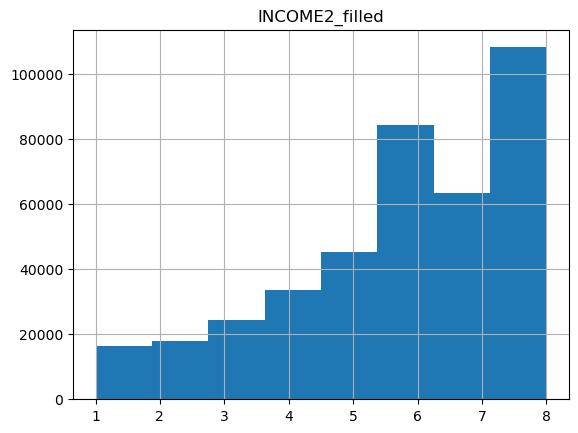

In [35]:
diabetesdata.hist('INCOME2_filled', bins=8)

This rather messed up the distribution. The reason is found in the regression plot from before. If you look at the density of points in the plot, you can see they are mostly clustered around 3 and a bit at 2. That translates to 6 in INCOME2 for the linear regression line. It turns out that the relationship between GENHLTH and INCOME2 was not a good choice.

This shows that it is always important to check and see if the imputation distorts anything. It is a very delicate art! Let's get rid of the bad column that messed up the distribution.

In [36]:
diabetesdata.drop("INCOME2_filled", inplace=True, axis=1)

Instead, let's go with using the histogram for INCOME2 as a probability distribution for filling in the missing values. It would have been better to have had a more accurate method but it was not to be. At this point, it would be better to drop the missing values altogether since we have a lot of data, but again for educational purposes, we will continue with the random probability.

First thing we need is the distribution from the histogram. `np.histogram` will do that. This will get us the weights for the random number generator.

In [37]:
weights = np.histogram(diabetesdata["INCOME2"].dropna(), bins=8)[0]
weights

array([ 16479,  17908,  24445,  29600,  36285,  48383,  54426, 108231])

And we will also need the number of missing values in the INCOME2 column

In [38]:
num_income_nan = sum(diabetesdata["INCOME2"].isna())
num_income_nan

57768

Then we can generate random numbers using the weights.

In [39]:
randomincome = np.random.choice(np.arange(1, 9), p=weights/sum(weights), size=num_income_nan)

And then assign random numbers to the missing values. This time we won't use INCOME2_filled, but just overwrite the INCOME2 column.

In [40]:
diabetesdata.loc[pd.isna(diabetesdata['INCOME2']), 'INCOME2'] = randomincome

Our data is now complete. There are no more missing values.

In [41]:
diabetesdata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 393525 entries, 0 to 441455
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   BPHIGH4   393525 non-null  Int64  
 1   _AGEG5YR  393525 non-null  Int64  
 2   BMI       393525 non-null  Float64
 3   SEX       393525 non-null  object 
 4   GENHLTH   393525 non-null  Int64  
 5   TOLDHI2   393525 non-null  Float64
 6   INCOME2   393525 non-null  Float64
 7   SMOKE100  393525 non-null  Int64  
 8   DIABETE3  393525 non-null  Int64  
dtypes: Float64(3), Int64(5), object(1)
memory usage: 33.0+ MB


We should double check the histogram again to see if the distribution changed significantly.

array([[<Axes: title={'center': 'INCOME2'}>]], dtype=object)

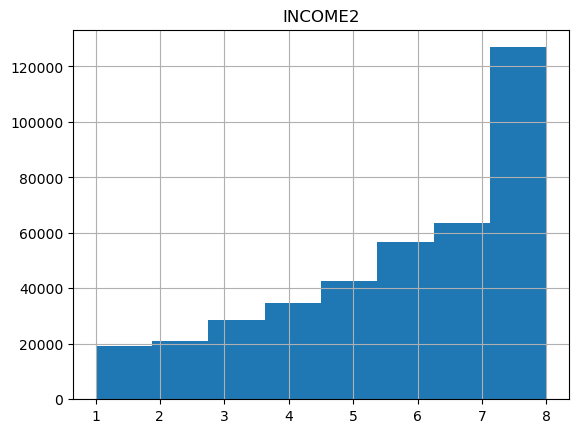

In [42]:
diabetesdata.hist('INCOME2', bins=8)

This looks the same as before, so we are good. We now have a clean dataset.

## Balancing the dataset

The next thing to check is to see if the dataset is balanced, meaning if there are roughly equal number of outcomes you are interested in. This is important because if you have 1000x more of something, then the model will become heavily biased towards predicting that as an outcome. After all, if you have a dataset with 1000x YES and 10x NO, then a model that simply always outputs YES will be 99% correct.

Let's use our histogram to visualize how balanaced or unbalanced DIABETE3 is.

array([[<Axes: title={'center': 'DIABETE3'}>]], dtype=object)

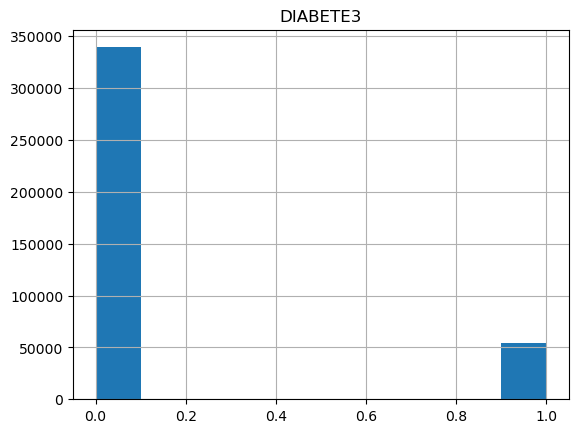

In [43]:
diabetesdata.hist('DIABETE3')

There is about seven times more 0 (no) than there is 1 (yes). That's not very balanced. There are two ways we can balance this. We can make six additional copies of the rows with DIABETE3 equal to 1 (called oversampling) or we can make it balanced by keeping only 1/7 of the rows where DIABETE3 is 0 and discarding the other 6/7 (called undersampling). Since we have lots of data, we'll go with undersampling.

There are many ways of doing this. We'll create a random mask that is true 1/7 of the time, which we can use to randomly select 1/7 of the entries of a Pandas DataFrame.

In [44]:
random_mask = np.random.rand(len(diabetesdata)) > 6./7.

And then we combine that mask where we say that we should keep the row if DIABETE3 is 1. This way only 1/7 of the DIABETE3=0 rows will be kept, as well as all the rows where DIABETE3=1.

In [45]:
diabetesdatabalanced = diabetesdata[random_mask | (diabetesdata["DIABETE3"] == 1)]

array([[<Axes: title={'center': 'DIABETE3'}>]], dtype=object)

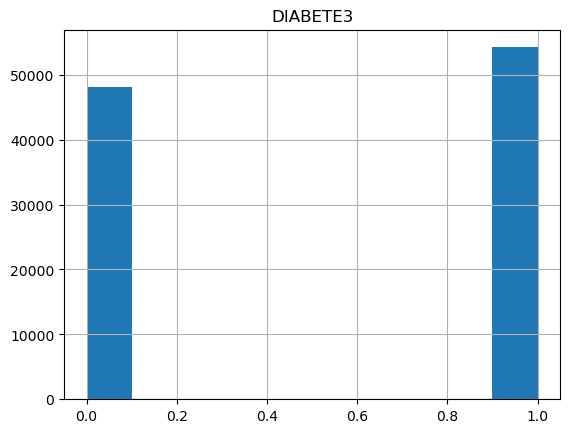

In [46]:
diabetesdatabalanced.hist('DIABETE3')

The data looks pretty evenly distributed now!

As a final step, we'll just reset the index. Because we deleted a fair number of rows, the row indices are no longer consecutive. Resetting the index renumbers all the rows. This is not strictly necessary but it looks cleaner and it might prevent subtle issues later on.

We'll also make a copy and delete the original dataset from memory to free up some memory.

In [54]:
diabetesdatabalanced = diabetesdatabalanced.copy()
diabetesdatabalanced.reset_index(inplace=True)
diabetesdatabalanced.drop('index', axis=1, inplace=True)
del diabetesdata

## Building the model

We finally have a dataset that we can work with. It's also a very good example that a lot of the work for creating a machine learning model is cleaning up the data. It should not be underestimated!

Now, let's create the KNN model. We'll have to choose a value for $k$. Since we have more than 100,000 data points, we can pick fairly large values for $k$. However, be aware that picking very large values of $k$ will make the model run slowly due to the amount of neighbouring points it needs to check. Here we will pick $k=501$.

In [64]:
X = diabetesdatabalanced[["BPHIGH4","_AGEG5YR","BMI","SEX","GENHLTH","TOLDHI2","INCOME2","SMOKE100"]]
y = diabetesdatabalanced['DIABETE3']

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=42)
neigh = KNeighborsClassifier(n_neighbors=501)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
accuracy_score(y_test, y_pred)

0.7259809672793638

So that's about 72.6%, which isn't too bad but not great either. We did that with $k=501$ but maybe other values would have better results. This is called *Hyperparameter optimization*. That is tuning the parameter of the algorithm itself.

For KNN, it's pretty easy, we can just iterate over various values of $k$ and see what works best. Scikit Learn has built-in methods for this as well, so let's just use those.

In [57]:
from sklearn.model_selection import GridSearchCV

We need to specify a range in which `GridSearchCV` will look for optimized parameters. We should be using only odd values of $k$ because it avoids ties when comparing neighbouring points for binary choices (yes/no for diabetes). For example, for $k=4$, if two neighbouring points say yes and two neighbouring points say no, then what do you choose? That problem doesn't occur for odd values of $k$.

Other things we can tune is the distance metric. The default is Minkowski which calculates the distance in the "normal" way for $p=2$. That is, $d = \sqrt{x^2 + y^2}$, but you could also have $p=1$ which is "city block" or "Manhattan" where $d = \lvert x \rvert + \lvert y \rvert$. The one for $p=3$ is pretty weird, but why not? That's $d = \sqrt[3]{\lvert x \rvert^3 + \lvert y \rvert^3}$.

We put all these ranges in a variable called `param_grid` which we can then feed for `GridSearchCV`. It will run multiple training sessions to try and find the most optimal parameters. For larger models this could take quite a while. KNN is very fast to train but the speed of using the model depends a lot on the size of the dataset. In this case, we have over 100,000 points, so it will take quite a while. Ways to mitigate this would be to use the `sample` function in Pandas to take only a small subset of the full dataset.

In [69]:
param_grid = {
    'n_neighbors': range(251,752,100),
    'p': range(1,4)
}

In [70]:
gridsearch = GridSearchCV(neigh, param_grid, scoring='accuracy')
gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(n_neighbors=501),
             param_grid={'n_neighbors': range(251, 752, 100), 'p': range(1, 4)},
             scoring='accuracy')

In [71]:
gridsearch.best_params_

{'n_neighbors': 251, 'p': 1}

In [72]:
gridsearch.best_score_

np.float64(0.7317334850613826)

With $k=251$ and $p=1$, the KNN model performs slightly better! However, beware that the improvement is very small. If you run this notebook again with a different `random_state` for the `train_test_split`, you might get different outcomes because the test/train set will be split differently every time you specify a different random seed and thus the model results will be slightly different.

In any case, it doesn't seem like we can push this model much higher than 75% accuracy. That means it will be wrong 1 out of 4 times, which isn't acceptable for predicting a medical condition but it could still be useful when combined with follow-up tests. It all depends on context.

Another thing to keep in mind is that this model was trained on data about a very specific group of people: adults in the US. This means the training data may be biased and not representative of all populations. There might be genetics or other determinants of health that affect the results, and the model will not be applicable to people who aren't represented in the training data (children and people in other countries). As always with machine learning, the input data is key to the quality of the model.

# Privacy Survey Example

The k-nearest neighbour algorithm does not always work. As an example of **failure**, let's look at using KNN to predict responses to survey questions. We will see there is simply not enough correlation between the answers to the other questions and the one we are trying to predict.

## Data
We will use a dataset from Canada's Open Government Portal. In this case, the "2022-23 Survey of Canadians on privacy-related issues", which is based on phone interviews with 1,500 Canadians ([Source](https://open.canada.ca/data/en/dataset/897a64fd-619d-48cc-b056-c9f6484b63b1)).

Suppose we want to classify our respondents based on the answers they give. KNN could be a good algorithm for this since the answers to the questions would hopefully put people in neat boxes as all the questions are somewhat related to each other.

KNN is a supervised learning algorithm, which means it needs to have labels to learn from. One approach is to have a bunch of group members label a bunch of the surveys manually, and then have the rest of the surveys be classified by the KNN algorithm. It's a lot less work than labelling them all manually.

However, that's still a lot of work and we don't want to go into that. Instead, we'll just use one of the questions as a label. For example, one of the questions is "In general, are you concerned about the protection of your privacy?". We want to predict the answer to this question based on the answers to all of the other survey questions. This is still useful because if you can predict this question with near-100% accuracy, then you don't really need to include this question in subsequent surveys and thus make it shorter and more likely for people to complete.

In [95]:
survey = pd.read_csv('../data/MLTS_20241205_KNN_2022-23_survey_canadians_dataset_1.0.csv')
survey

QUEST  STYPE LANG  QF  Q1  Q2  Q3A  Q3B Q4A Q4B  ...  Q20M1  Q20M2  \
0        228      2   EN   6   4   7    2    2       2  ...      2          
1        349      2   FR   5   1   5    5    5   4      ...      2          
2       1019      2   EN   5   2   7    5    5   6      ...      1          
3       1109      2   FR   5   1   7    7    7       7  ...      2          
4       1208      2   EN  10   2   7    6    6       5  ...      1          
...      ...    ...  ...  ..  ..  ..  ...  ...  ..  ..  ...    ...    ...   
1495  263855      1   EN   2   1   3    3    1   2      ...      1          
1496  263883      1   EN   2   1   7    4    4   4      ...      1          
1497  263889      1   EN   2   2   6    5    3   4      ...      1          
1498  263926      1   EN   2   2   7    4    4       6  ...      1          
1499  264106      1   EN   2   3   3    3    4       2  ...      1          

      Q20M3  Q21  Q22  Q23  Q24  AGE_COL  REGION    WEIGHT  
0              2    2    1    4        3       3  1.470245  
1              2    2    1    7        3       2  0.853297  
2              2   99   99    7        2       2  1.578553  
3              2    2    1    7        3       2  0.853297  
4              2   99    2    3        3       5  1.068920  
...     ...  ...  ...  ...  ...      ...     ...       ...  
1495           2    2    2    1        4       1  0.378720  
1496           2    2   99    4        3       1  0.811720  
1497           2    2    2    2        4       1  0.378720  
1498           2    2    2    6        4       1  0.378720  
1499           2    2    2    6        4       1  0.378720  

[1500 rows x 54 columns]

This is extremely cryptic data with coded variables and values. Fortunately, there is a data dictionary that comes with this data set, which you can view in the file "2022-23_survey_canadians_dictionary.csv". The question we want to predict is Q2. The answers range from 1 to 7 but other options are 98 (don't know) and 99 (refused). Let's drop those 98 and 99 responses.

In [97]:
survey = survey[survey['Q2'] <= 7]

Let's corrolate Q2 with the answers from a bunch of other questions, for example:

* 3A. How would you rate your knowledge of your privacy rights?
* 3B. How would you rate your knowledge of how to protect your privacy rights?
* 4A. How much you agree or disagree with the following statements: I feel that businesses in general respect my privacy rights.
* 4B. How much you agree or disagree with the following statements: I feel that the Government of Canada in general respects my privacy rights.
* 4C. How much you agree or disagree with the following statements: I am confident that I have enough information to know how new technologies might affect my personal privacy.
* 4D. Do you know what to do if you receive a notification from an organization about a privacy breach?

Looking closer at Q4A and Q4B in the table above, they seem to be mutually exclusive. Let's confirm if that's true. Pandas lets you do boolean operations and with `sum` it will tell you the number of times `True` occurs.

In [99]:
sum((survey['Q4A'] != ' ') & (survey['Q4B'] != ' '))

0

It looks like people were asked to respond to either question 4A or 4B, but not both. The difference is that 4A asks about businesses and 4B asks about government. So what to do here?

We can merge them and assume that people will trust governments and business in equal measure. Or we can create two separate datasets, one with the question about government and one with businesses.

The one thing we cannot do is to just set it to zero because KNN will look at the nearest neighbours. This would just group people that didn't get 4A close to people that answered 1 (Strongly disagree) on question 4B.

We'll go with the merging:

In [101]:
survey = survey.assign(Q4AB=(survey['Q4A'] + survey['Q4B']).astype('int'))

First, let's get rid of the other "Don't know" and "Refused" answers

In [103]:
survey = survey[(survey['Q3A'] <= 7) & (survey['Q3B'] <= 7) & (survey['Q4AB'] <= 7) & (survey['Q4C'] <= 7) & (survey['Q4D'] <= 7)]

Let's look at the pair plot again to see if we can get similar patterns as with the Penguins dataset that can be distinguished.

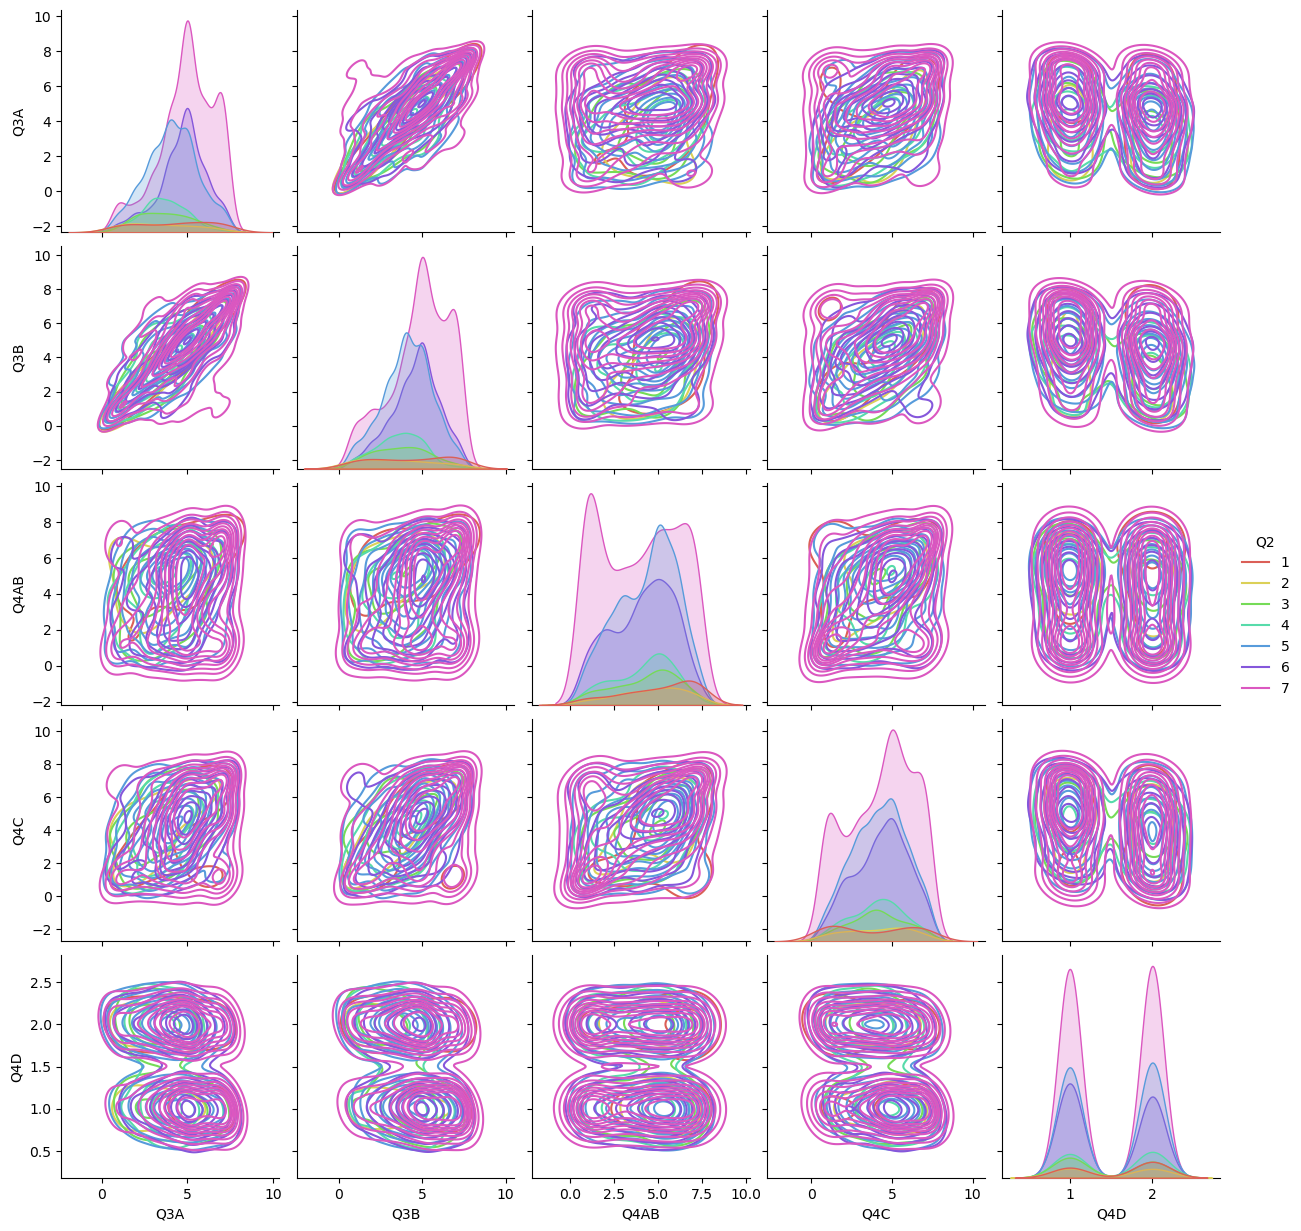

In [105]:
sns.pairplot(survey[['Q3A', 'Q3B', 'Q4AB', 'Q4C', 'Q4D', 'Q2']], hue='Q2', kind="kde", palette=sns.color_palette('hls',7))

Well, that does not look promising. There doesn't seem to be any relation. Just a tiny bit in Q3A and Q3B. However, as we saw before with the diabetes dataset, this doesn't necessarily mean that there is no hope at all. In this case, we have fewer features though so it does not bode well. Let's try it anyway and see what happens.

In [107]:
X = survey[['Q3A', 'Q3B', 'Q4AB', 'Q4C', 'Q4D']]
y = survey['Q2']

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=42)
neigh = KNeighborsClassifier(n_neighbors=7)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
accuracy_score(y_test, y_pred)

0.3247058823529412

That is only a 32% accuracy, which is not great! This tells us that the question "2. In general, are you concerned about the protection of your privacy?" does not really depend on the answers to the other questions that we picked. It appears to indeed be an independent question, so we cannot use KNN in this case since there is not a strong enough correlation.

# Book Genres Example

This is another example of **failure**. This probably didn't work out because of the *curse of dimensionality*, which says that if your input data has a very high number of dimensions (in this case a 74000 word input vector!) and a lot of those columns are actually mostly random, then that essentially guarantees the points will just be very far from each other even if some columns are relevant.

See the Naive Bayes tutorial for an example of a machine learning algorithm where this dataset will work. For now, let's go through the steps of preparing the data.
## Data
We will use the CMU Book Summary Dataset at https://www.cs.cmu.edu/~dbamman/booksummaries.html. It is included in this repository.

This dataset is tab separated without a header row. Column names comes from the accompying README. We'll read the data using Pandas.

In [110]:
books = pd.read_csv('../data/MLTS_20241205_KNN_booksummaries_1.0.txt', sep="\t", header=0, names=['wikipedia', 'freebase', 'title', 'author', 'publicationdate', 'genres', 'summary'])

This dataset contains a number of rows with missing data. However, there are so many books that we can simply drop the incomplete rows without the risk of not having enough data. KNN works better with moderately-sized datasets. That is, several thousands or tens of thousands of rows. It depends a lot on your processing power and the memory you have available.

In [112]:
books = books.dropna()
books.head()

wikipedia  freebase                            title                author  \
0        843   /m/0k36               A Clockwork Orange       Anthony Burgess   
1        986   /m/0ldx                       The Plague          Albert Camus   
4       2152   /m/0x5g   All Quiet on the Western Front  Erich Maria Remarque   
5       2890  /m/011zx             A Wizard of Earthsea     Ursula K. Le Guin   
7       4081  /m/01b4w  Blade Runner 3: Replicant Night           K. W. Jeter   

  publicationdate                                             genres  \
0            1962  {"/m/06n90": "Science Fiction", "/m/0l67h": "N...   
1            1947  {"/m/02m4t": "Existentialism", "/m/02xlf": "Fi...   
4      1929-01-29  {"/m/098tmk": "War novel", "/m/016lj8": "Roman...   
5            1968  {"/m/0dwly": "Children's literature", "/m/01hm...   
7      1996-10-01  {"/m/06n90": "Science Fiction", "/m/014dfn": "...   

                                             summary  
0   Alex, a teenager living in near-future Englan...  
1   The text of The Plague is divided into five p...  
4   The book tells the story of Paul Bäumer, a Ge...  
5   Ged is a young boy on Gont, one of the larger...  
7   Living on Mars, Deckard is acting as a consul...

Genres are in a JSON format, so we will need the JSON package to extract those.

In [114]:
import json

Convert that JSON into a simple list. Since we don't care about the weird identifiers, we'll only use the values and not the keys of the JSON dictionaries.

In [116]:
def genre(row):
    g = json.loads(row.genres)
    return list(g.values())

genresperbook = books.apply(genre, axis=1)
books = books.assign(genres=genresperbook)

The genres column should now be replaced with a list of genres instead of JSON data.

In [118]:
books.head()

wikipedia  freebase                            title                author  \
0        843   /m/0k36               A Clockwork Orange       Anthony Burgess   
1        986   /m/0ldx                       The Plague          Albert Camus   
4       2152   /m/0x5g   All Quiet on the Western Front  Erich Maria Remarque   
5       2890  /m/011zx             A Wizard of Earthsea     Ursula K. Le Guin   
7       4081  /m/01b4w  Blade Runner 3: Replicant Night           K. W. Jeter   

  publicationdate                                             genres  \
0            1962  [Science Fiction, Novella, Speculative fiction...   
1            1947  [Existentialism, Fiction, Absurdist fiction, N...   
4      1929-01-29                          [War novel, Roman à clef]   
5            1968  [Children's literature, Fantasy, Speculative f...   
7      1996-10-01             [Science Fiction, Speculative fiction]   

                                             summary  
0   Alex, a teenager living in near-future Englan...  
1   The text of The Plague is divided into five p...  
4   The book tells the story of Paul Bäumer, a Ge...  
5   Ged is a young boy on Gont, one of the larger...  
7   Living on Mars, Deckard is acting as a consul...

## Feature extraction
Unlike the penguins example, we now want to predict multiple labels. One way we can do this is by creating a dummy column, like we did for the islands before, and have a dummy column for each genre.

The following code does that. It's fairly dark magic and, full transparency, it is mostly just copied from StackOverflow. What it does is that it takes the lists in the genres column and converts them each to a Pandas Series. Then it stacks those series back on top of the other to form a full DataFrame again while keeping the main index, but with a sub index for each genre per book. Then we get the dummies for those genres. The end result of all that is a single multi-indexed DataFrame but now with a column for every genre per book per listed genre for that book. Each book will have a row with for each genre since the genre is the second index of this multi-indexed DataFrame.

We only want one row per book, so we need to collapse the multi-index back into a single-index DataFrame again. That is, we want to get rid of the secondary genre index. We do this by grouping all that by the first index of our multi-index DataFrame which is the index for the books. We sum on that which means that for each book we now have a single row with a column for each genre that has a 1 if that book is part of that genre and 0 if not. Then we add a prefix to the column name to clearly identify each genre.

In [120]:
dummies = books.genres.apply(pd.Series).stack().str.get_dummies().groupby(level=0).sum().add_prefix('genre_')
books = books.join(dummies)

In [121]:
books

wikipedia    freebase                            title  \
0            843     /m/0k36               A Clockwork Orange   
1            986     /m/0ldx                       The Plague   
4           2152     /m/0x5g   All Quiet on the Western Front   
5           2890    /m/011zx             A Wizard of Earthsea   
7           4081    /m/01b4w  Blade Runner 3: Replicant Night   
...          ...         ...                              ...   
16548   36372465  /m/02vqwsp                   The Third Lynx   
16550   36534061   /m/072y44                   Remote Control   
16554   37054020  /m/04f1nbs                Transfer of Power   
16555   37122323  /m/0n5236t                          Decoded   
16557   37159503   /m/073nkd                        Poor Folk   

                     author publicationdate  \
0           Anthony Burgess            1962   
1              Albert Camus            1947   
4      Erich Maria Remarque      1929-01-29   
5         Ursula K. Le Guin            1968   
7               K. W. Jeter      1996-10-01   
...                     ...             ...   
16548          Timothy Zahn            2007   
16550            Andy McNab            1997   
16554           Vince Flynn      2000-06-01   
16555                 Jay-Z      2010-11-16   
16557    Fyodor Dostoyevsky            1846   

                                                  genres  \
0      [Science Fiction, Novella, Speculative fiction...   
1      [Existentialism, Fiction, Absurdist fiction, N...   
4                              [War novel, Roman à clef]   
5      [Children's literature, Fantasy, Speculative f...   
7                 [Science Fiction, Speculative fiction]   
...                                                  ...   
16548                                  [Science Fiction]   
16550                      [Thriller, Fiction, Suspense]   
16554                                [Thriller, Fiction]   
16555                                    [Autobiography]   
16557            [Epistolary novel, Speculative fiction]   

                                                 summary  \
0       Alex, a teenager living in near-future Englan...   
1       The text of The Plague is divided into five p...   
4       The book tells the story of Paul Bäumer, a Ge...   
5       Ged is a young boy on Gont, one of the larger...   
7       Living on Mars, Deckard is acting as a consul...   
...                                                  ...   
16548   The story starts with former government agent...   
16550   The series follows the character of Nick Ston...   
16554   The reader first meets Rapp while he is doing...   
16555   The book follows very rough chronological ord...   
16557   Makar Devushkin and Varvara Dobroselova are s...   

       genre_Absurdist fiction  genre_Adventure  genre_Adventure novel  ...  \
0                            0                0                      0  ...   
1                            1                0                      0  ...   
4                            0                0                      0  ...   
5                            0                0                      0  ...   
7                            0                0                      0  ...   
...                        ...              ...                    ...  ...   
16548                        0                0                      0  ...   
16550                        0                0                      0  ...   
16554                        0                0                      0  ...   
16555                        0                0                      0  ...   
16557                        0                0                      0  ...   

       genre_Utopian fiction  genre_Vampire fiction  genre_War novel  \
0                          0                      0                0   
1                          0                      0                0   
4                          0                      0   

Phew!! Now the data is in a form we can use for the labels.

Let's look a bit closer at the genres and in particular how many books we have in each category. We'll just sum the dummy columns for genres.

In [123]:
genreusage = books.drop(['wikipedia', 'freebase', 'author', 'publicationdate', 'genres', 'title', 'summary'], axis=1).sum().sort_values(ascending=False)
genreusage

genre_Fiction                3674
genre_Speculative fiction    3270
genre_Novel                  2088
genre_Science Fiction        2001
genre_Fantasy                1863
                             ... 
genre_Prose                     1
genre_Photography               1
genre_Indian chick lit          1
genre_Superhero fiction         1
genre_Neuroscience              1
Length: 215, dtype: int64

There are several genres that only have one book in the dataset. As you can imagine, this is not going to work well when training the model. So let's put in a minimum limit of say 200 books per category. How many genres do we still have?


In [125]:
genreusage = genreusage.reset_index().rename(columns={0: "count"})
genreusage = genreusage[genreusage["count"] > 200]
genreusage

index  count
0                  genre_Fiction   3674
1      genre_Speculative fiction   3270
2                    genre_Novel   2088
3          genre_Science Fiction   2001
4                  genre_Fantasy   1863
5    genre_Children's literature   1627
6                  genre_Mystery    973
7   genre_Young adult literature    625
8            genre_Crime Fiction    557
9         genre_Historical novel    551
10                genre_Suspense    538
11                genre_Thriller    429
12                  genre_Horror    383
13           genre_Romance novel    316
14      genre_Historical fiction    314
15         genre_Adventure novel    268

We have 16 genres that we may be able to distinguish. Let's make an ordinary Python list out of the remaining genres, so we can loop over it later.

In [127]:
genretrainlist = list(genreusage["index"])
genretrainlist

['genre_Fiction',
 'genre_Speculative fiction',
 'genre_Novel',
 'genre_Science Fiction',
 'genre_Fantasy',
 "genre_Children's literature",
 'genre_Mystery',
 'genre_Young adult literature',
 'genre_Crime Fiction',
 'genre_Historical novel',
 'genre_Suspense',
 'genre_Thriller',
 'genre_Horror',
 'genre_Romance novel',
 'genre_Historical fiction',
 'genre_Adventure novel']

In [128]:
dummies = dummies[genretrainlist]

## Input
Next is the input. These are the summaries for a book, which is essentially a collection of words. We can vectorize that by making a vector that has a length of however many unique words there are in all the summaries combined. Then each book summary can be represented as a vector that counts the number of words.

That sounds complicated, but fortunately, Scikit can do it for us.

In [130]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [131]:
# Create the vectorizer
count_vect = CountVectorizer()

In [132]:
# Apply the vectorizer to the book summaries
X = count_vect.fit_transform(books.summary)

The result is a large matrix with a column for each of the unique words in the entire corpus. The rows contain how often each word is used in a book summary. As you can imagine, this will mean a lot of zeros since it is unlikely that a single book summary will contain at least one of every possible word in the entire corpus. The vectorizer therefore creates a "sparse matrix" instead, which is a format that only stores non-zero elements and is much more memory efficient for matrices with large numbers of zeros.

In [134]:
X[0]

<1x90759 sparse matrix of type '<class 'numpy.int64'>'
	with 486 stored elements in Compressed Sparse Row format>

We'll then convert the counts into frequencies which are numbers between 0 and 1 just as KNN likes it.

In [136]:
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X)

## Train

Now we can train the KNN model as we did before. However, let's just try a bunch of different values for $k$, ranging from 5 to 55. To evaluate the accuracy, we'll look at the accuracy score but also the Hamming loss, which shows the fraction of labels that were misassigned. It's between 0 and 1 where lower is better.

In [138]:
y = dummies

scaler = MaxAbsScaler()
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=42)

for k in range(5, 56, 10):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    print(f"k = {k}")
    print(accuracy_score(y_test, y_pred))
    print(hamming_loss(y_test, y_pred))
    print()

k = 5
0.011477761836441894
0.15826757532281205

k = 15
0.00430416068866571
0.20460455523672882

k = 25
0.04770444763271162
0.14125269010043043

k = 35
0.07065997130559541
0.13553622668579626

k = 45
0.08142037302725968
0.13138898852223815

k = 55
0.08034433285509325
0.13132173601147776



The accuracy increases a bit with increasing $k$ but it barely exceeds 8% which is pretty poor. However, only 13% of the labels are misassigned according to the Hamming loss, so that is a bit odd.

The trouble here is that the accuracy score is only considered to be correct if every single label is correctly predicted as yes or no for a book. So if a book is part of 4 genres but the KNN model predicts that it's also part of another genre, then it's considered to be inaccurate even though that's not really so bad.

Since accuracy isn't telling the whole story, let's just pick our model for $k=35$ and work with that. It's a fair number, given the number of data rows we have. Feel free to use any other number though.

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=42)
neigh = KNeighborsClassifier(n_neighbors=35)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)

As a reminder, these are the genres we are working with:

In [142]:
dummies.columns

Index(['genre_Fiction', 'genre_Speculative fiction', 'genre_Novel',
       'genre_Science Fiction', 'genre_Fantasy', 'genre_Children's literature',
       'genre_Mystery', 'genre_Young adult literature', 'genre_Crime Fiction',
       'genre_Historical novel', 'genre_Suspense', 'genre_Thriller',
       'genre_Horror', 'genre_Romance novel', 'genre_Historical fiction',
       'genre_Adventure novel'],
      dtype='object')

Now let's look per genre if the label was predicted correctly or not. We'll iterate over all of the genres and then we check the accuracy score for all books in the test dataset.

In [144]:
for i in range(0,len(dummies.columns)):
    print(f"{dummies.columns[i]:<30}: {accuracy_score(np.array(y_test.iloc[:,i]), np.array(y_pred[:,i])):.2f}")

genre_Fiction                 : 0.51
genre_Speculative fiction     : 0.65
genre_Novel                   : 0.77
genre_Science Fiction         : 0.78
genre_Fantasy                 : 0.81
genre_Children's literature   : 0.83
genre_Mystery                 : 0.90
genre_Young adult literature  : 0.93
genre_Crime Fiction           : 0.94
genre_Historical novel        : 0.95
genre_Suspense                : 0.94
genre_Thriller                : 0.96
genre_Horror                  : 0.96
genre_Romance novel           : 0.96
genre_Historical fiction      : 0.97
genre_Adventure novel         : 0.97


That is much better. It looks like KNN can predict with stunning accuracy. However, if we look at bit deeper at, for example, Adventure novel, which is index 15, and we look at the confusion matrix we get a different picture. A confusion matrix tells you the true/false positives/negatives as
$$\left[\begin{array}{cc}\text{True negatives} & \text{False positives} \\ \text{False negatives} & \text{True positives}\end{array}\right]$$


In [146]:
confusion_matrix(np.array(y_test.iloc[:,15]), np.array(y_pred[:,15]))

array([[2712,    0],
       [  76,    0]])

So that is really odd! We have many true negatives, meaning that books not part of the adventure novel genre were correctly classified as not being part of that genre. However, we also have many false negatives, meaning that these books were part of the adventure novel genre but were classified as not being part of the genre. There are also no positives at all. The KNN model simply didn't classify any books as belonging to the adventure novel genre!

The reason for the high accuracy earlier was simply because there were so many books that were not part of the adventure novel genre (2712) that the ones that were part of the genre (76) were vastly outnumbered.

So watch out with solely relying on the accuracy measurement. It doesn't alway tell the whole story. Accuracy scores generally work best for balanced data where there are roughly an equal amount of "yes" and "no" labeled data.

Even if we look at the one for Fiction (index 0), it doesn't work very well.

In [148]:
confusion_matrix(np.array(y_test.iloc[:,0]), np.array(y_pred[:,0]))

array([[846, 829],
       [526, 587]])

It's basically 50:50 for determining if a book is classified as fiction. That means it's just as good as randomly guessing.

So all in all, the KNN model is not terribly good at predicting genres of books for a couple of reasons. The main reason is that KNN does not work well when there are too many features, especially if many of those features do not contribute to classifying and are essentially random noise. For every unnecessary feature, more random noise is added to the distance measure causing it to become ever more unreliable.

The other reason is that we didn't do any specific cleaning of the data with regards to language. This is a complex topic and the subject is covered in the tutorial called "Natural Language Processing". Feel free to continue exploring machine learning in any of the other tutorials listed one [our page](https://uottawa-it-research-teaching.github.io/machinelearning/).